# Load Modules

In [29]:
import os
import glob
import numpy as np
from numpy.fft import fft, ifft, fftfreq
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import isc, isfc, isps, fdr, threshold, phase_randomize, circle_shift, _butter_bandpass_filter, _phase_mean_angle, _phase_vector_length
from nilearn.plotting import view_img_on_surf, view_img
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from scipy.stats import ttest_1samp
from scipy.signal import hilbert
import networkx as nx
from IPython.display import HTML

base_dir = '/mnt/c/Users/since/Desktop/KdramaApril/'
story_dir = '/mnt/c/Users/since/Dropbox/Lab/Projects/CJY/_DATA'
data_dir = os.path.join(base_dir, 'data', 'derivatives')
denoised_dir = os.path.join(base_dir, 'analysis', 'denoised')
Zdenoised_dir = os.path.join(base_dir, 'analysis', 'denoised_zscore')


spring_dir = '/mnt/c/Users/since/Desktop/KdramaSpring/'
sdata_dir = os.path.join(spring_dir, 'data', 'derivatives')
sZdenoised_dir = os.path.join(spring_dir, 'analysis', 'denoised_zscore')

/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


## Load mask

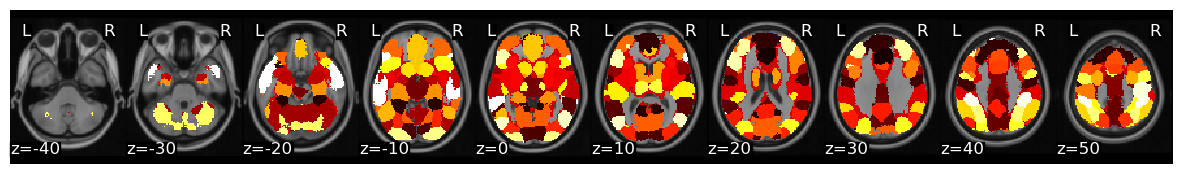

In [11]:
from nltools.mask import expand_mask
mask = Brain_Data('http://neurovault.org/media/images/2099/Neurosynth%20Parcellation_0.nii.gz')
#mask_x = expand_mask(mask)

#mask = Brain_Data(os.path.join(base_dir,'analysis', 'Masks', 'k50_2mm.nii.gz'))
mask_x = expand_mask(mask)

mask.plot()

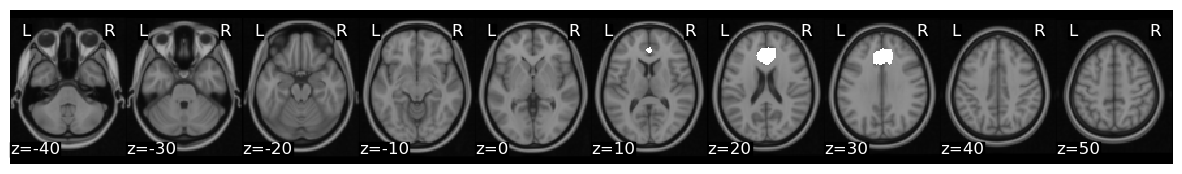

In [12]:
mask_x[0].plot()

/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/image/resampling.py:274: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "



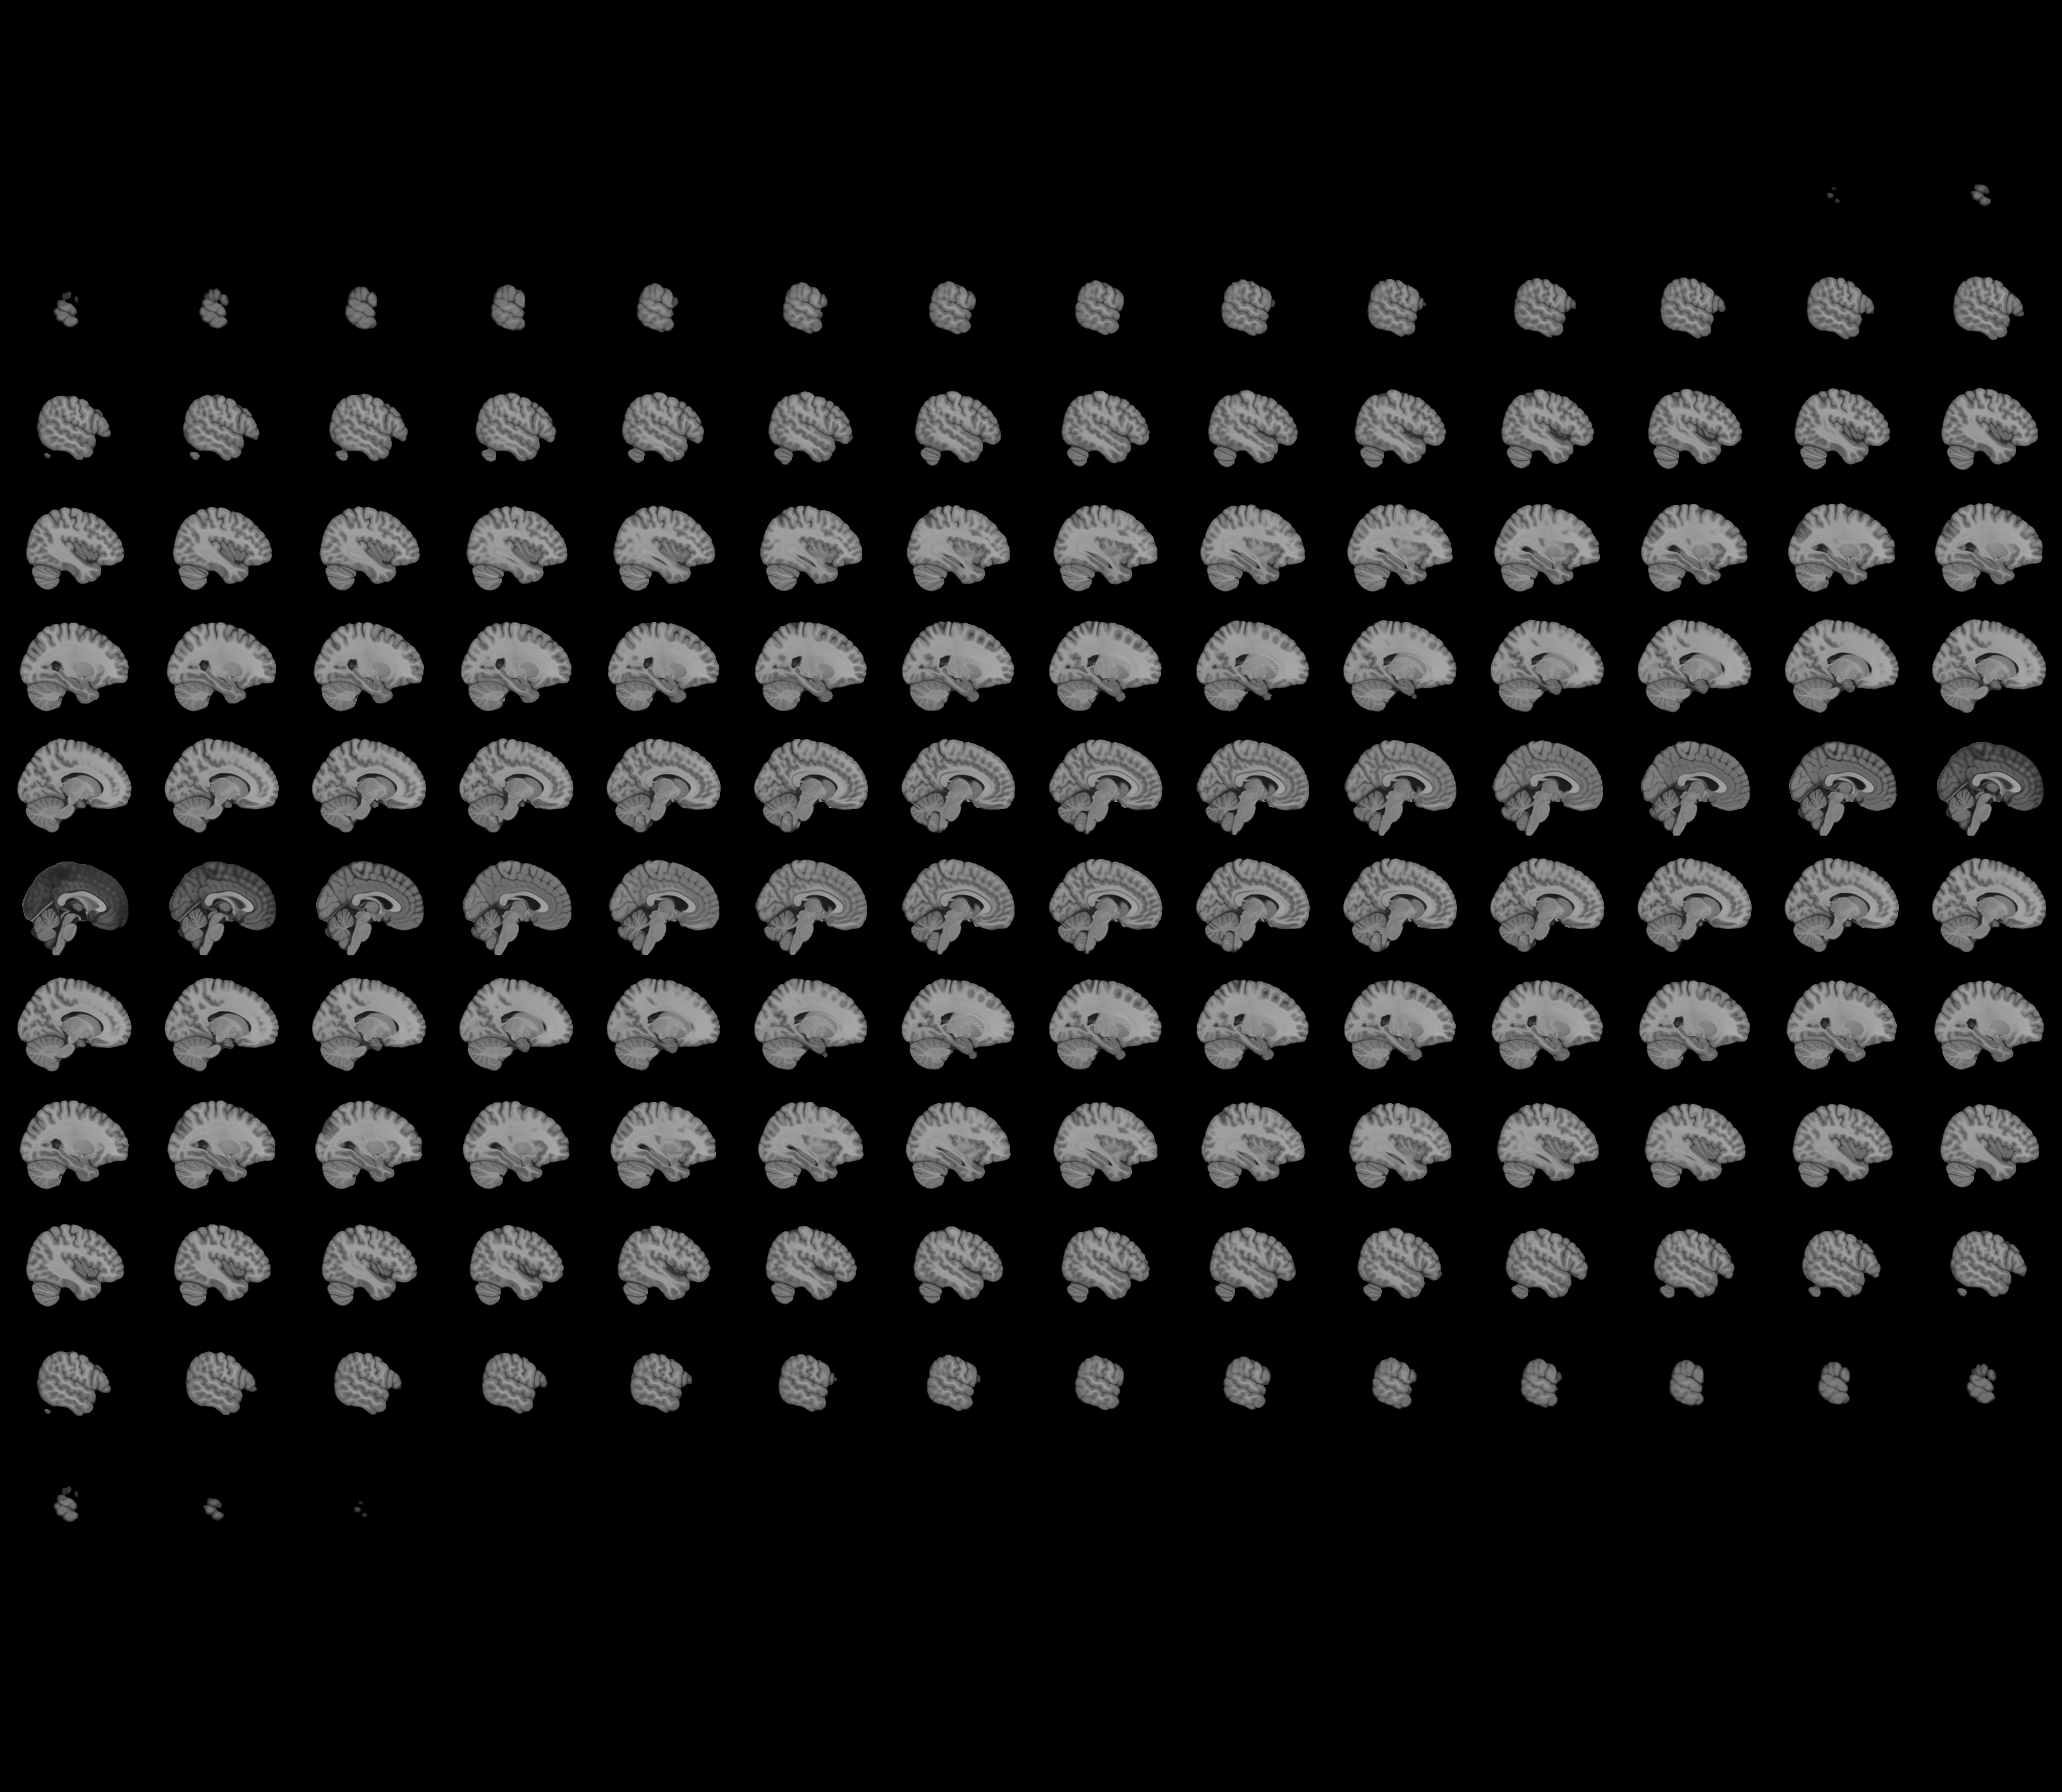
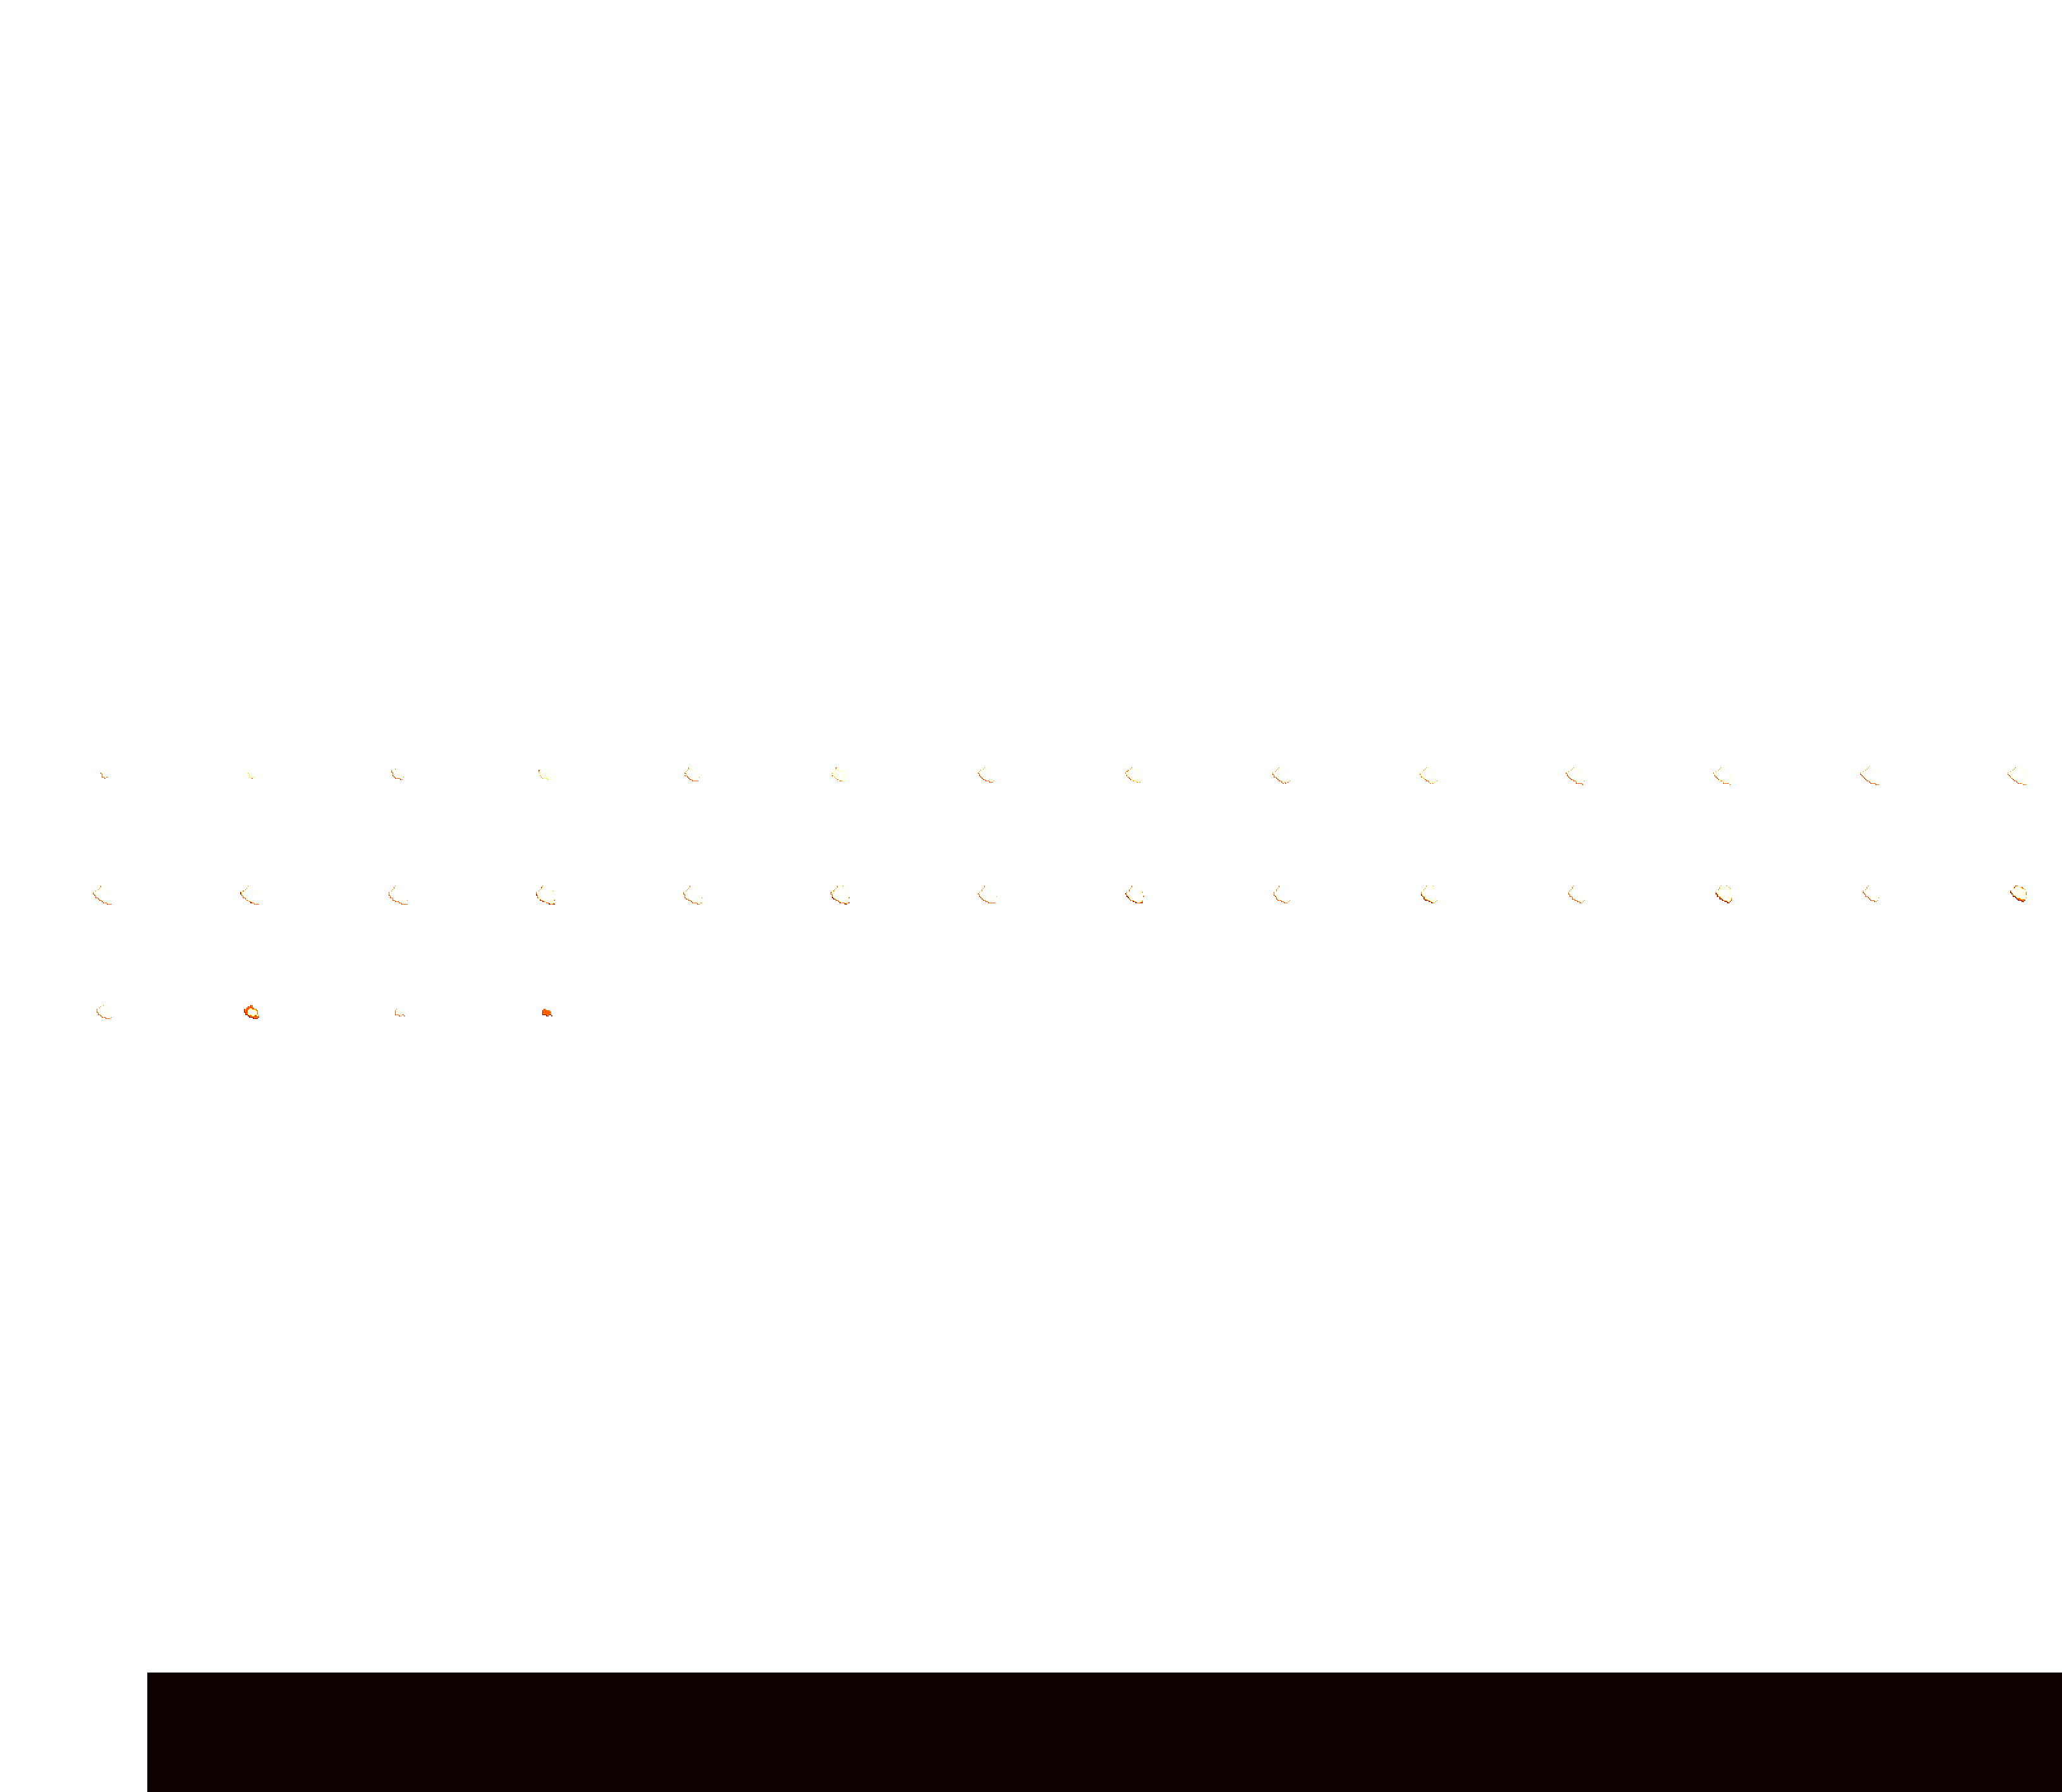

In [13]:
from nilearn.plotting import view_img_on_surf, view_img
view_img(mask_x[0].to_nifti())

In [35]:
rois = pd.read_csv('https://raw.githubusercontent.com/naturalistic-data-analysis/tutorial_development/master/hypertools/rois.csv', header=None, names=['ID', 'Region'])
rois

ID                                             Region
0    0                                      Anterior MPFC
1    1                           Fusiform/parahippocampus
2    2                                              DMPFC
3    3                     Sensorimotor/postcentral gyrus
4    4                                                 V1
5    5         TPJ posterior supra marginal/angular gyrus
6    6                                      PCC/precuneus
7    7                                           Thalamus
8    8                                                SMA
9    9                                   Precentral gyrus
10  10                                    Cerebellum (VI)
11  11                        Temporal occipital fusiform
12  12                                           Amygdala
13  13                            Superior temporal gyrus
14  14                                       White matter
15  15  TPJ anterior supra marginal gyrus/parietal ope...
16  16                                         Mid insula
17  17                                            Putamen
18  18                             Dorsal anterior insula
19  19                                   PCC/superior LOC
20  20          Lateral occipital/temporal occipital (V2)
21  22                                               DACC
22  23              Anterior fronto-parietal (DLPFC/DACC)
23  24                              Intercalcarine cortex
24  25                                     Anterior VLPFC
25  26                                         Left motor
26  27                                           Left IFG
27  28                                        Hippocampus
28  29                                     Dorsal caudate
29  32                                              VMPFC
30  34                                               NACC
31  35                                                 A1
32  37                            Ventral anterior insula
33  39                                       Superior LOC
34  42                                  Cerebellum (crus)
35  44                                              DLPFC
36  45                                    Right IFG VLPFC
37  46                                       Inferior LOC
38  47                                        Right motor
39  48                                      Somatosensory
40  49                                                STS

## Load story sequences

In [22]:
import scipy.io as sio
#for sub in subjects: 

all_story = {}
subjects = ['1', '2', '3', '4']
for sub in subjects:
    mat = sio.loadmat(glob.glob(os.path.join(story_dir, 'fMRItdsgn', 'fMRI_April', f'sub-{sub}_*.mat'))[0])
    story = []
    for i in np.arange(0,8):
        temp = mat['subj'][0][0][5][0][i][0]
        story = np.append(story, temp)
    all_story[sub] = story
all_story

subjects = ['5', '6']
for sub in subjects:
    mat = sio.loadmat(glob.glob(os.path.join(story_dir, 'recall', 'Movie_Spring', f'sub-0{sub}_task-recall_countered-*_stimulusCond-*_*.mat'))[0])
    story = ['Neighbors']
    for i in np.arange(0,4):
        temp_story = mat['data'][0][0][7][0][i][0]
        story = np.append(story, temp_story)
    all_story[sub] = story
    
# sub-08 
mat = sio.loadmat(glob.glob(os.path.join(story_dir, 'recall', 'Movie_Spring', 'sub-102_task-recall_counter-*_session-01_cond-1_clock-*.mat'))[0])
story2 = ['Dream']
for i in np.arange(0,6):
    stroy2 = mat['data'][0][0][8][0][i]
    story2 = np.append(story2, stroy2)
#All_story
story2 = np.insert(story2, 4, 'King')
all_story['8'] = story2

all_story['2'] = np.delete(all_story['2'], (4,5,6,7))
all_story

{'1': array(['Dream', 'BlindDate', 'TwoBoys', 'BusinessLunch', 'King',
        'WayToSchool', 'Neighbors', 'RunningMan'], dtype='<U32'),
 '2': array(['King', 'TwoBoys', 'BusinessLunch', 'RunningMan'], dtype='<U32'),
 '3': array(['Dream', 'Neighbors', 'TwoBoys', 'BusinessLunch', 'King',
        'WayToSchool', 'BlindDate', 'RunningMan'], dtype='<U32'),
 '4': array(['Dream', 'BlindDate', 'RunningMan', 'BusinessLunch', 'King',
        'WayToSchool', 'Neighbors', 'TwoBoys'], dtype='<U32'),
 '5': array(['Neighbors', 'Runningman', 'First Date', 'Way To School',
        'Business Lunch'], dtype='<U14'),
 '6': array(['Neighbors', 'Runningman', 'Business Lunch', 'Way To School',
        'First Date'], dtype='<U14'),
 '8': array(['Dream', 'Blind Date', 'Way To School', 'Business Lunch', 'King',
        'Runningman', 'neighbors', 'TwoBoys'], dtype='<U14')}

# Calculte Correlation

condition 간 sliding time window corr를 보기 위해서는 먼저 Averaged_ROI 파일이 필요하다.
이 파일은 Denoised 코드에 포함되어 있음.

## Trimming stories

In [16]:
# Onset & offset -- setsize 6 일 경우 

onset = [11, 121, 241, 361] 
offset = [127, 237, 357, 477]  
sub_story_timeseries = {}
for sub in ['1','3', '4']:
    story = {}
    data = pd.read_csv(os.path.join(Zdenoised_dir,'averaged_ROIs', f'sub-0{sub}_task-encoding_run-1_Average_ROI_n50.csv'))
    data2 = pd.read_csv(os.path.join(Zdenoised_dir,'averaged_ROIs', f'sub-0{sub}_task-encoding_run-2_Average_ROI_n50.csv'))
    data3 = pd.read_csv(os.path.join(Zdenoised_dir,'averaged_ROIs', f'sub-0{sub}_task-encoding_run-3_Average_ROI_n50.csv'))
    data4 = pd.read_csv(os.path.join(Zdenoised_dir,'averaged_ROIs', f'sub-0{sub}_task-encoding_run-4_Average_ROI_n50.csv'))
    
    for i in np.arange(0,4):
        story[i] = {'visual' : data[onset[i]:offset[i]], 'audio' : data2[onset[i]:offset[i]]}
        story[i+4] =  {'visual' : data3[onset[i]:offset[i]], 'audio' : data4[onset[i]:offset[i]]}

    sub_story_timeseries[sub] = story

for sub in ['8']:
    story = {}
    data = pd.read_csv(os.path.join(sZdenoised_dir,'Averaged_ROI', f'sub-0{sub}_run-1_Average_ROI_n50.csv'))
    data2 = pd.read_csv(os.path.join(sZdenoised_dir,'Averaged_ROI', f'sub-0{sub}_run-2_Average_ROI_n50.csv')) 
    data3 = pd.read_csv(os.path.join(sZdenoised_dir,'Averaged_ROI', f'sub-0{sub}_run-3_Average_ROI_n50.csv'))
    data4 = pd.read_csv(os.path.join(sZdenoised_dir,'Averaged_ROI', f'sub-0{sub}_run-4_Average_ROI_n50.csv')) 
    
    for i in np.arange(0,4):
        story[i] = {'visual' : data[onset[i]:offset[i]], 'audio' : data2[onset[i]:offset[i]]}
        story[i+4] =  {'visual' : data3[onset[i]:offset[i]], 'audio' : data4[onset[i]:offset[i]]}
        
    sub_story_timeseries[sub] = story  
    
for sub in ['2']:
    story = {}
    data = pd.read_csv(os.path.join(Zdenoised_dir,'averaged_ROIs', f'sub-0{sub}_task-encoding_run-1_Average_ROI_n50.csv'))
    data2 = pd.read_csv(os.path.join(Zdenoised_dir,'averaged_ROIs', f'sub-0{sub}_task-encoding_run-2_Average_ROI_n50.csv'))    
    
    for i in np.arange(0,4):
        story[i] = {'visual' : data[onset[i]:offset[i]], 'audio' : data2[onset[i]:offset[i]]}
    
    sub_story_timeseries[sub] = story #<-----------------------------sub/story/run 
    

In [17]:
# Onset & offset -- setsize 4 일 경우 
onset = [11, 131, 251, 371, 491]
offset = [127, 247, 367, 487, 607] 

subjects = ['5', '6']
#sub_story_timeseries = {}
for sub in subjects:
    story = {}
    data = pd.read_csv(os.path.join(sZdenoised_dir,'Averaged_ROI', f'sub-0{sub}_run-1_Average_ROI_n50.csv'))
    data2 = pd.read_csv(os.path.join(sZdenoised_dir,'Averaged_ROI', f'sub-0{sub}_run-2_Average_ROI_n50.csv')) 

    for i in np.arange(0,5):
        story[i] = {'visual' : data[onset[i]:offset[i]], 'audio' : data2[onset[i]:offset[i]]}

    sub_story_timeseries[sub] = story


## Select interest ROIs 

In [292]:
ROIs = {}
for roi in [5, 28, 32]:
    sub_rois = {}
    for sub in ['1', '3', '4', '8']:
    #for sub in ['8']:
        story_roi = {}
        for j in np.arange(0,8):
            story_timeseries = sub_story_timeseries[sub][j]
            run_rois = {}
            for run in ['visual', 'audio']:
                story_timeseries = sub_story_timeseries[sub][j][run]
                run_rois[run]  = story_timeseries.iloc[:, roi]
            story_roi[j] = pd.DataFrame(run_rois)
        sub_rois[sub] = story_roi
    ROIs[roi] = sub_rois

In [18]:
# SetSize - 6 stories 
ROIs = {}
# for roi in [5, 28, 32]:
for roi in [1, 4, 5, 6, 15, 19, 27, 28, 32, 45]:
    sub_rois = {}
    for sub in ['1', '3', '4', '8']:
        story_roi = {}
        for j in np.arange(0,8):
            story_timeseries = sub_story_timeseries[sub][j]
            run_rois = {}
            for run in ['visual', 'audio']:
                run_rois[run]  = story_timeseries[run].iloc[:, roi]
            story_roi[j] = pd.DataFrame(run_rois)
        sub_rois[sub] = story_roi
    ROIs[roi] = sub_rois
    
    for sub in [ '2']:
        story_roi = {}
        for j in np.arange(0,4):
            run_rois = {}
            story_timeseries = sub_story_timeseries[sub][j]
            for run in ['visual', 'audio']:
                run_rois[run]  = story_timeseries[run].iloc[:, roi]
            story_roi[j] = pd.DataFrame(run_rois)
        sub_rois[sub] = story_roi
    ROIs[roi] = sub_rois
    
    for sub in ['5', '6']:
        story_roi = {}
        for j in np.arange(0,5):
            run_rois = {}
            story_timeseries = sub_story_timeseries[sub][j]
            for run in ['visual', 'audio']:
                run_rois[run]  = story_timeseries[run].iloc[:, roi]
            story_roi[j] = pd.DataFrame(run_rois)
        sub_rois[sub] = story_roi
    ROIs[roi] = sub_rois


## Sliding Window analysis with Correlation (ISC codes) 

In [20]:
import pandas as pd
from tqdm import tqdm


#roi =28 
# 슬라이딩 타임 윈도우 크기 및 간격 설정
window_size = 30 #TR - 60secs 
stride = 1  # 윈도우 이동 간격 (TR 단위)
#sub = '1'

All_sliding_r = {}
All_sliding_p = {}
for roi in tqdm([1, 4, 5, 6, 15, 19, 27, 28, 32, 45]):
    sub_rois = ROIs[roi]
    sub_sliding_r = {}
    sub_sliding_p = {}
    #for sub in ['1','3','4']:
    #for sub in ['2','5','6','8']:
    for sub in ['1','3','4','5','6','8']:
        storyNum = all_story[sub]
        sliding_r = {}
        sliding_p = {}
        for num in np.arange(storyNum.shape[0]):
            data = pd.DataFrame(sub_rois[sub][num]).reset_index(drop = True)
            window_isc_r = []
            window_isc_p = []
            for i in range(0, data.shape[0] - window_size + 1, stride):
                window = data.iloc[i:i + window_size]
                
                stats = isc(window, n_bootstraps=5000, metric='median', method='bootstrap', exclude_self_corr=True) #Same Subject multiple repeat option : exclude_self_corr=True
                window_isc_r.append(stats['isc'])
                window_isc_p.append(stats['p'])
            result_r = pd.Series(window_isc_r, index=data.index[window_size - 1:])
            result_p = pd.Series(window_isc_p, index=data.index[window_size - 1:])
             
            sliding_r[storyNum[num]] = result_r
            sliding_p[storyNum[num]] = result_p
        sub_sliding_r[sub] = sliding_r
        sub_sliding_p[sub] = sliding_p
    All_sliding_r[roi] = sub_sliding_r
    All_sliding_p[roi] = sub_sliding_p

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [5:13:02<00:00, 1878.20s/it]
/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()
/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1120: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()
/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1120: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/sincerely/.co

## Transfrom ISC_r to Z socre for comparing!!!! 

In [23]:
import pandas as pd
# Trans Pearson p to Fisher Z 
ZROIs = {} 
for roi in tqdm([1, 4, 5, 6, 15, 19, 27, 28, 32, 45]):    
    Zsocres = {}
    for sub in ['1','3','4','5','6','8']:
        storyNum = all_story[sub]
        Z = {}
        for num in np.arange(storyNum.shape[0]): 
            rois = pd.DataFrame(All_sliding_r[roi][sub][storyNum[num]])
            Z[storyNum[num]] = np.arctanh(rois) 
        Zsocres[sub] = Z
    ZROIs[roi] = Zsocres

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 354.05it/s]


## Saved Data with Pickle

In [540]:
pwd

'/mnt/c/Users/since/Desktop/KdramaApril/analysis'

In [24]:
import pickle
# Save pickle

with open("zscores4slinding_corr_0511.pickle","wb") as fw:

    pickle.dump(ZROIs, fw)
    
with open("slinding_corr_r_0511.pickle","wb") as fw:

    pickle.dump(All_sliding_r, fw)
    
with open("slinding_corr_p_0511.pickle","wb") as fw:

    pickle.dump(All_sliding_p, fw)

# Plotting Event segmentation 

## Define Event TR

In [25]:
# S0[1-4,8]

#Run_event_TR = [11, 24, 42, 97]
#Neighbor_event_TR = [11, 22, 42, 94] 
#Business_event_TR = [11, 29, 80, 106]
#WTS_event_TR = [11, 35, 68, 111]
#Blind_event_TR = [11, 36, 60, 103]   
#TwoBoys_event_TR = [11, 14, 42, 116]
#King_event_TR = [11, 20, 54, 62, 98]
#Dream_event_TR = [11, 26, 88, 108]

story_TR = { 'RunningMan' :[11, 24, 42, 97], 'Neighbors' : [11, 22, 42, 94], 'BusinessLunch': [11, 29, 80, 106], 'WayToSchool': [11, 35, 68, 111], 'BlindDate': [11, 36, 60, 103] , 'TwoBoys' :[11, 14, 42, 116], 'King' : [11, 20, 54, 62, 98], 'Dream': [11, 26, 88, 108]} 

# S0[5-6] --> Rubric / Neighbors -- 3 mins but similar eventsegement  
story_TR2 = { 'Runningman' :[11, 24, 42, 97], 'Neighbors' : [11, 22, 42, 94], 'Business Lunch': [11, 29, 80, 106], 'Way To School': [11, 35, 68, 111], 'First Date': [11, 36, 60, 103] }  

#S08 
story_TR3 = { 'Runningman' :[11, 24, 42, 97], 'neighbors' : [11, 22, 42, 94], 'Business Lunch': [11, 29, 80, 106], 'Way To School': [11, 35, 68, 111], 'Blind Date': [11, 36, 60, 103] , 'TwoBoys' :[11, 14, 42, 116], 'King' : [11, 20, 54, 62, 98], 'Dream': [11, 26, 88, 108]} 


In [26]:
cd ../../../mnt/c/Users/since/Desktop/KdramaApril/analysis

[Errno 2] No such file or directory: '../../../mnt/c/Users/since/Desktop/KdramaApril/analysis'
/home/sincerely/jupyterlab/Movie-encoding/fMRI01


## Plot story * multi subjects 

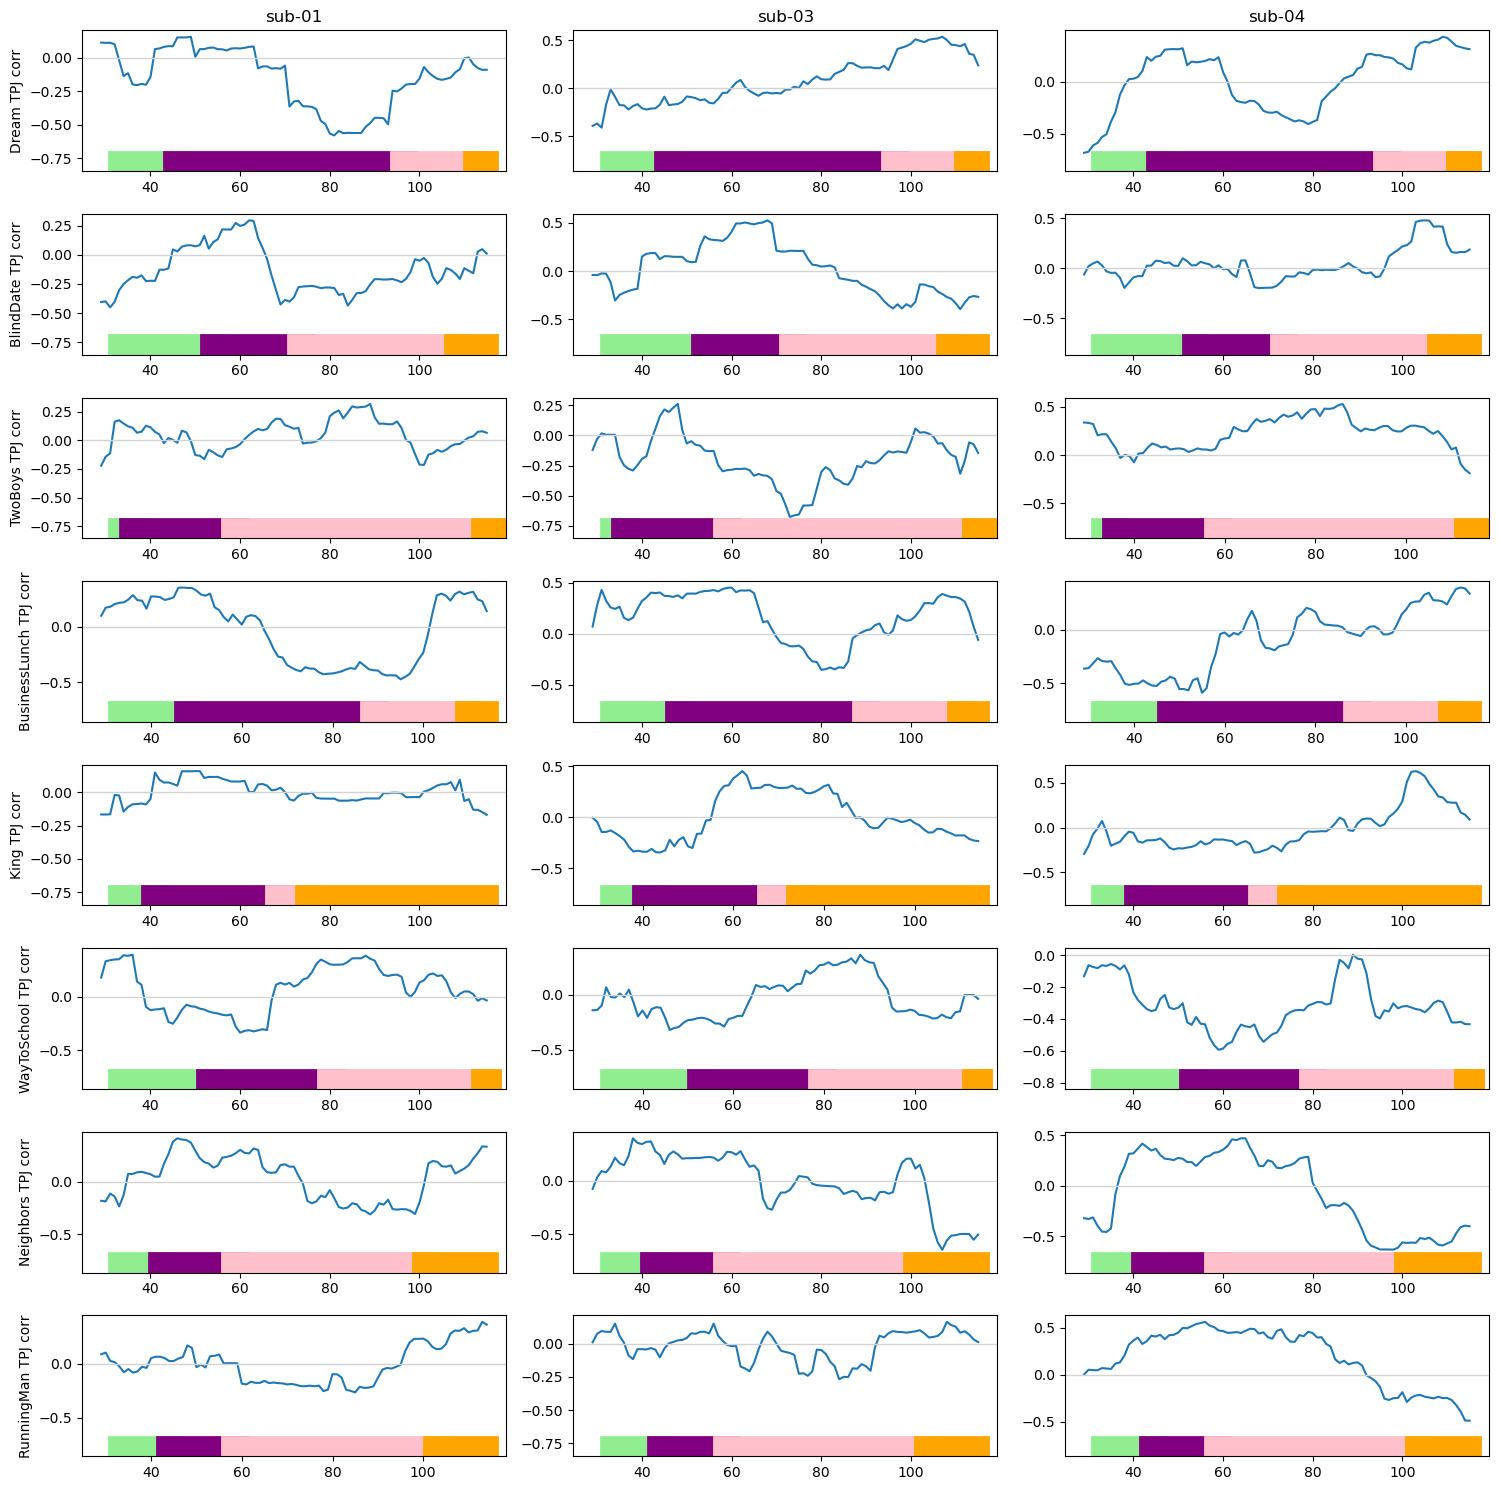

In [395]:
fig, axes = plt.subplots(8, 3, figsize = (15,15))     
#for position, sub in enumerate(['1','3','4']):  
for position, sub in enumerate(['1','3','4']):  
    for num in np.arange(all_story['1'].shape[0]):
        story = all_story['1'][num]
        axes[num, position].plot(pd.DataFrame(All_sliding_r[5][sub][story]))
        axes[0, position].set_title(f"sub-0{sub}")
        axes[num, 0].set_ylabel(f"{story} TPJ corr")
        axes[num, position].axhline(0.0, 0, 1.0, color='lightgray', linestyle='solid', linewidth=1)
        #plt.axhline(1.0, 11/110,Runningman_event_TR[0]/110,color='lightgray', linestyle='solid', linewidth=20)
        # axes[num, position].axhline(-0.8, 0.05,  story_TR[story][0]/116, color='lightblue', linestyle='solid', linewidth=20)
        axes[num, position].axhline(-0.8,  story_TR[story][0]/116, story_TR[story][1]/116, color='lightgreen', linestyle='solid', linewidth=20)
        axes[num, position].axhline(-0.8,  story_TR[story][1]/116, story_TR[story][2]/116, color='purple', linestyle='solid', linewidth=20)
        axes[num, position].axhline(-0.8,  story_TR[story][2]/116, story_TR[story][3]/116, color='pink', linestyle='solid', linewidth=20)
        axes[num, position].axhline(-0.8,  story_TR[story][3]/116,  0.95, color='orange', linestyle='solid',linewidth=20)
fig.tight_layout()
#axes[, 4].set_xlabel("30 TRs Window")
plt.show()
fig.savefig('roi-5_TPJ_S0[1-3].png')

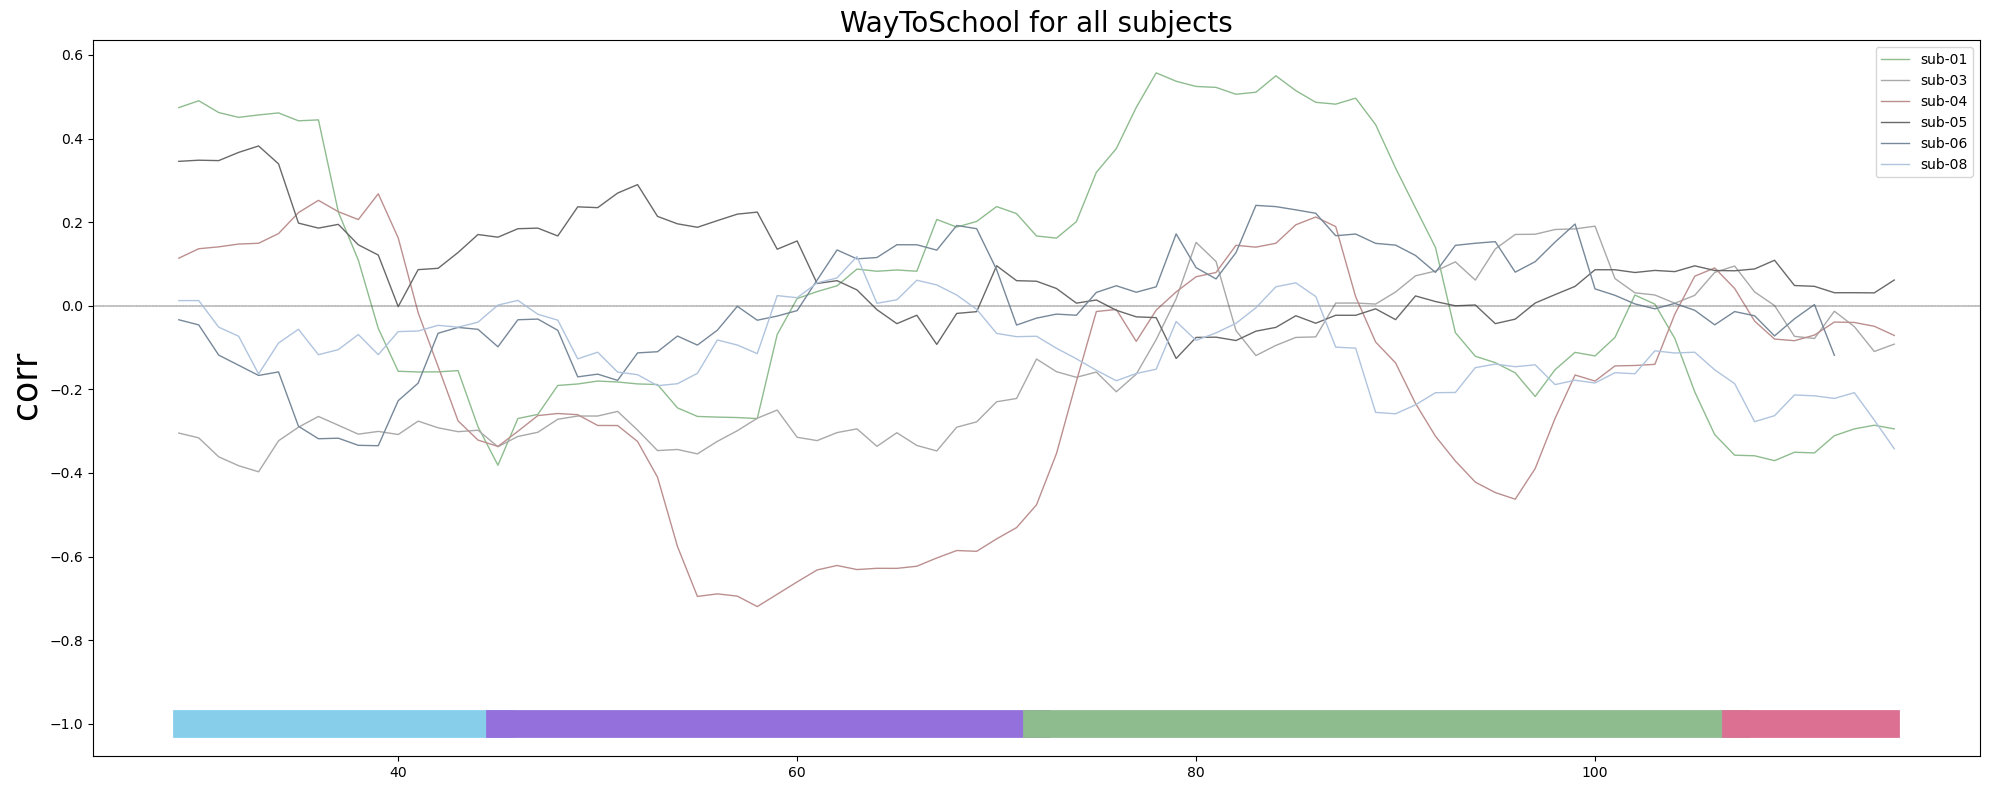

/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/masking.py:858: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)
/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/image/resampling.py:274: UserWarning: Resampling binary images 

In [111]:
# Plotting sub - 02 & 08 
#[1, 4, 5, 6, 15, 19, 27, 28, 32, 45] 

palette = ['darkseagreen', 'darkgray', 'rosybrown', 'dimgrey', 'lightslategray', 'lightsteelblue', 'cadetblue','silver']

fig, ax = plt.subplots(figsize = (20, 8))     
#for position, sub in enumerate(['1','3','4']):  
story1 = 'WayToSchool'
story2 = 'Way To School'
#story3 = 'Blind Date'
roi = 28
roiName = ' '
for num, sub in enumerate(['1','3','4','5','6','8']):
    if int(sub) < 5 :
        story = story1 
    elif int(sub)<8:
        story = 'First Date'
    else: 
        story = story2
    #story = 'Dream'
    #rois = pd.DataFrame(All_sliding_r[roi][sub][story]).reset_index(drop = True)
    plt.plot(pd.DataFrame(All_sliding_r[roi][sub][story]), color = palette[num], label = f'sub-0{sub}',  linewidth= 1)
    plt.title(f"{story1} for all subjects", fontsize = 20)
    plt.ylabel(f"{roiName} corr", fontsize = 25)
    plt.axhline(0.0, 0, 1.0, color='black', linestyle='--', linewidth= 0.08)
    #axes[num,0].axhline(-0.8, 0.05,  story_TR3[story][0]/116, color='lightblue', linestyle='solid', linewidth=20)

        
fig.tight_layout()

# timeline = t_Runningman.reset_index(drop = True)

# plt.plot(1-t_Neighbors, color = 'green', linewidth= 2, label ='Behavior Change')
# plt.fill_between(t_Runningman.index-10, 0.0, t_Runningman.loc[:,'cP']-1, color='lightgray', alpha=0.5)

#plt.plot(result_average_dynamic[story2], color = 'green', linewidth= 2, label ='Behavior Change')
#plt.fill_between(result_average_dynamic[story1].index, 0.0, result_average_dynamic[story2].loc[:], color='lightgray', alpha=0.5)

plt.axhline(-1.0,  0.05, (story_TR3[story][1]-10)/116, color='skyblue', linestyle='solid', linewidth=20)
plt.axhline(-1.0,  (story_TR3[story][1]-10)/116, (story_TR3[story][2]-10)/116, color='mediumpurple', linestyle='solid', linewidth=20)
plt.axhline(-1.0,  (story_TR3[story][2]-10)/116, (story_TR3[story][3]-10)/116, color='darkseagreen', linestyle='solid', linewidth=20)
plt.axhline(-1.0,  (story_TR3[story][3]-10)/116,  0.95, color='palevioletred', linestyle='solid',linewidth=20)

plt.legend(loc = 'upper right')
plt.show()



/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/masking.py:858: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)
/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/image/resampling.py:274: UserWarning: Resampling binary images 


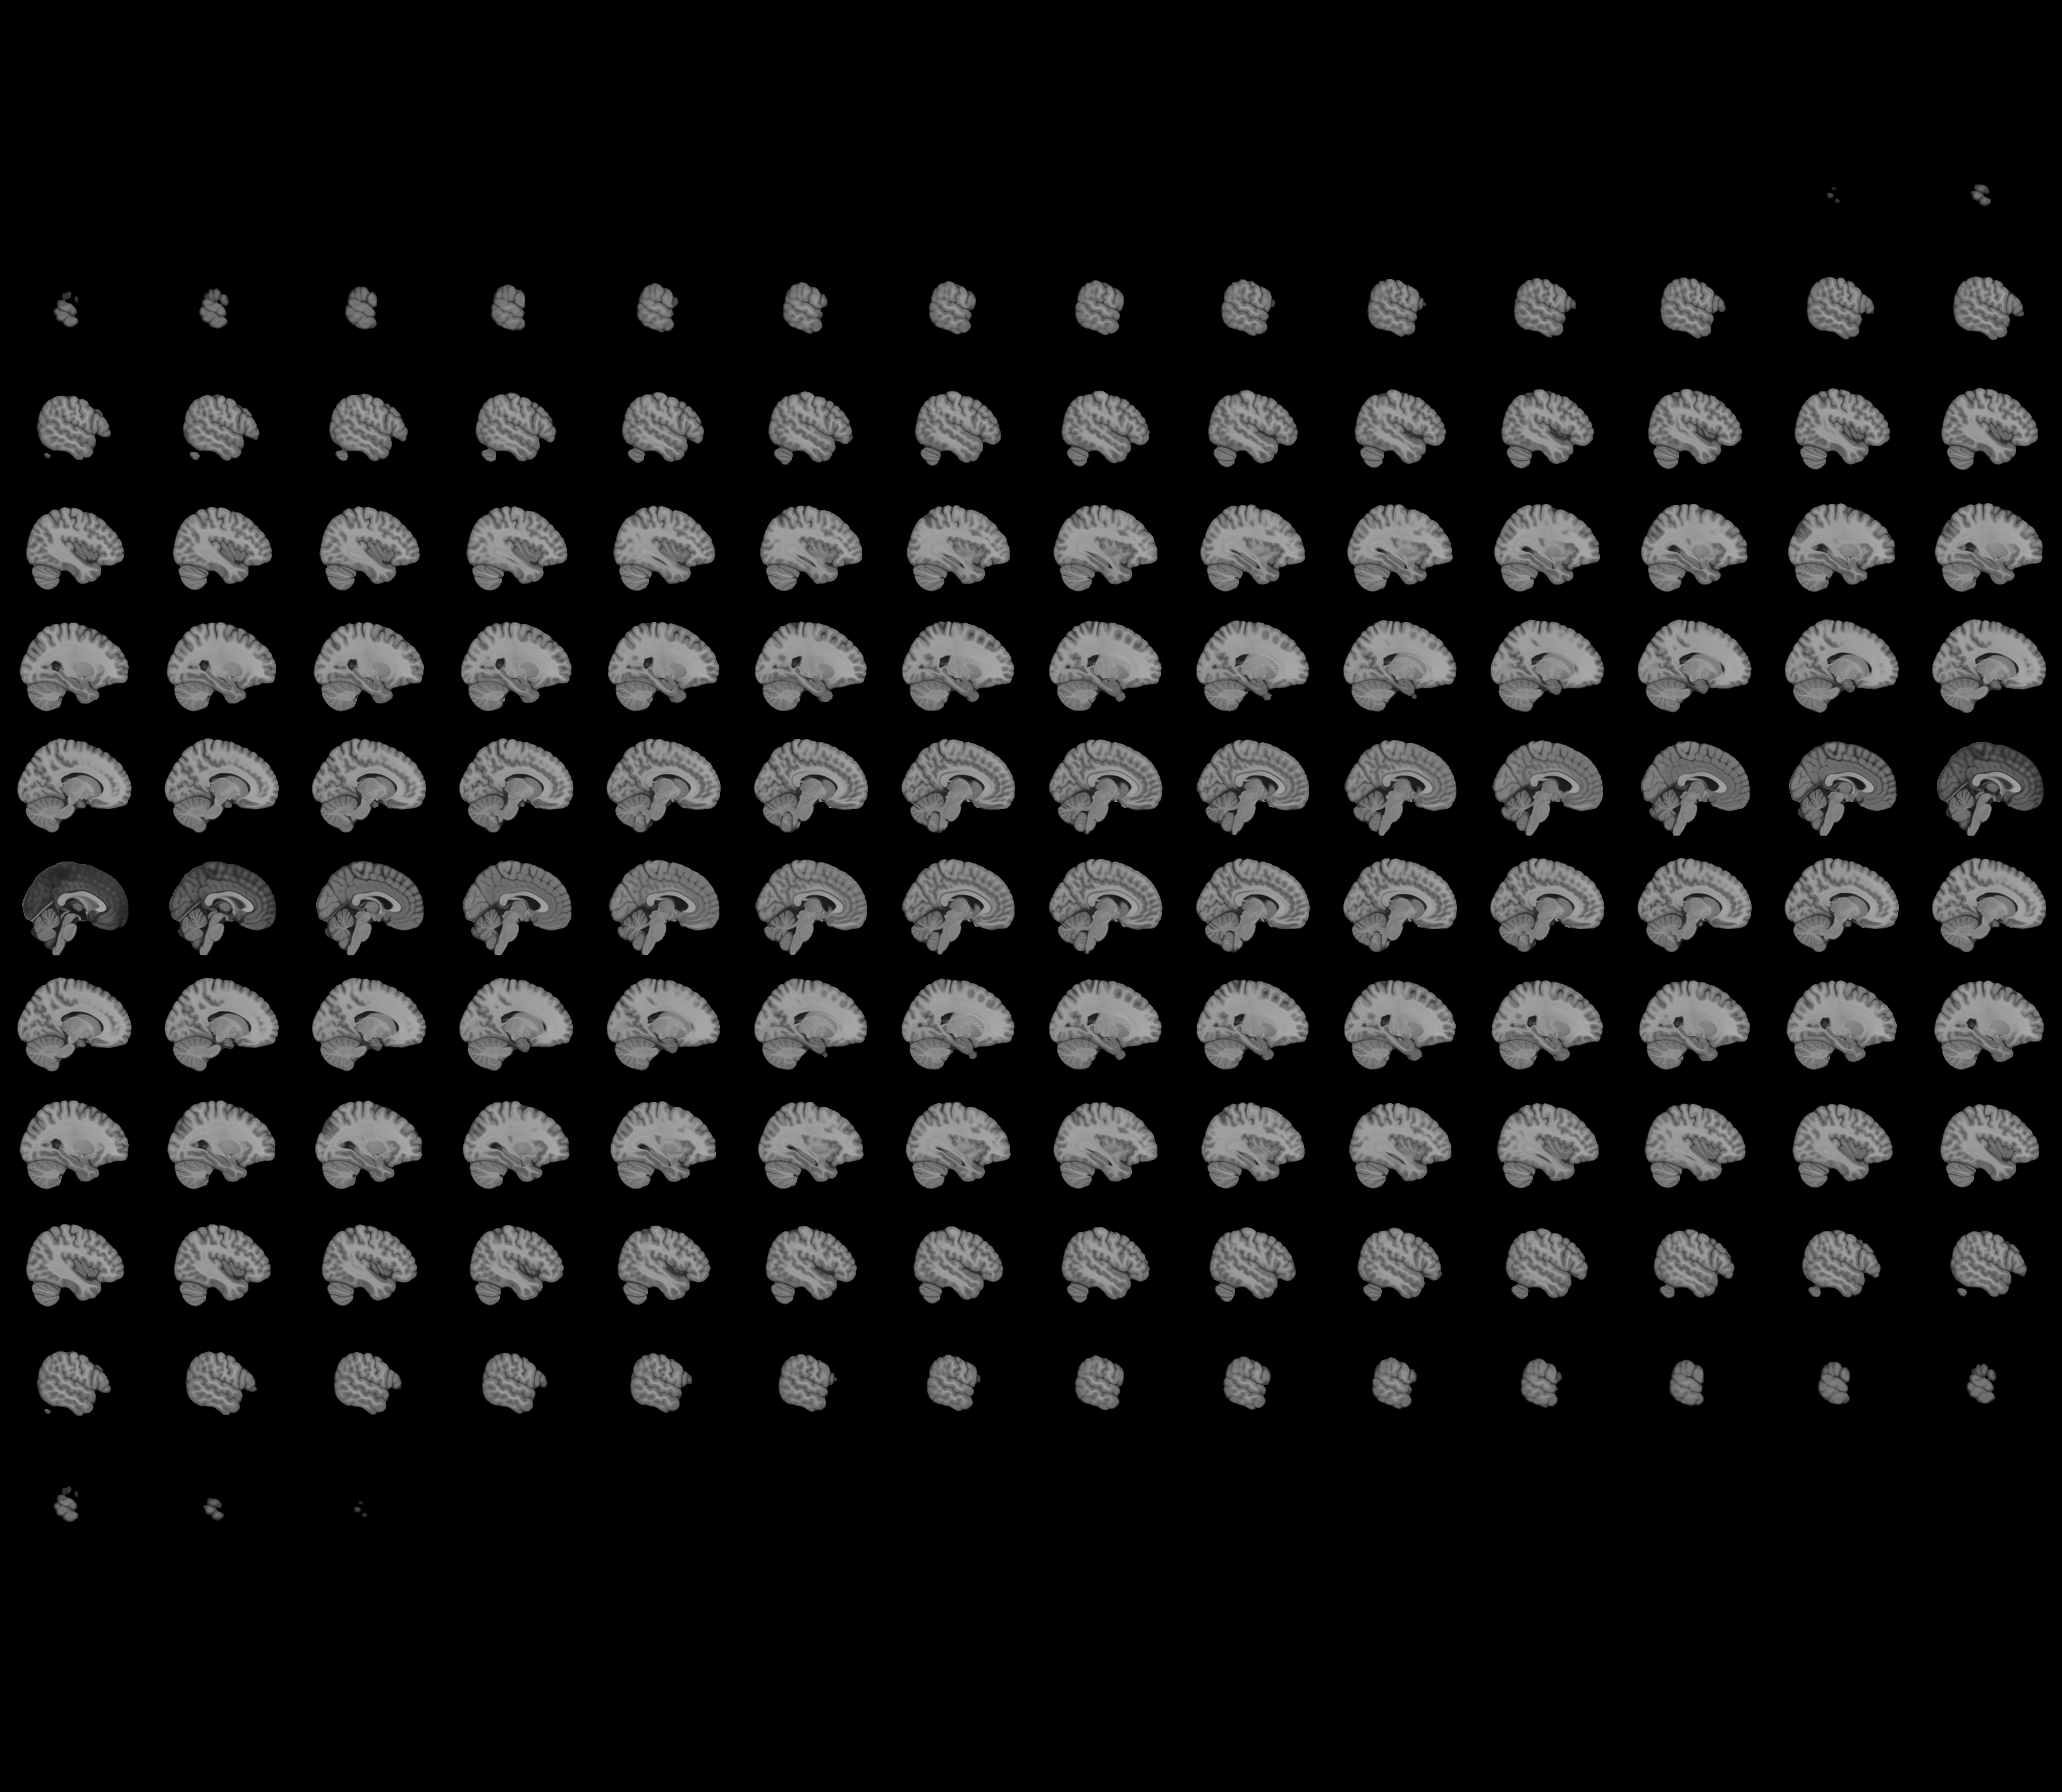
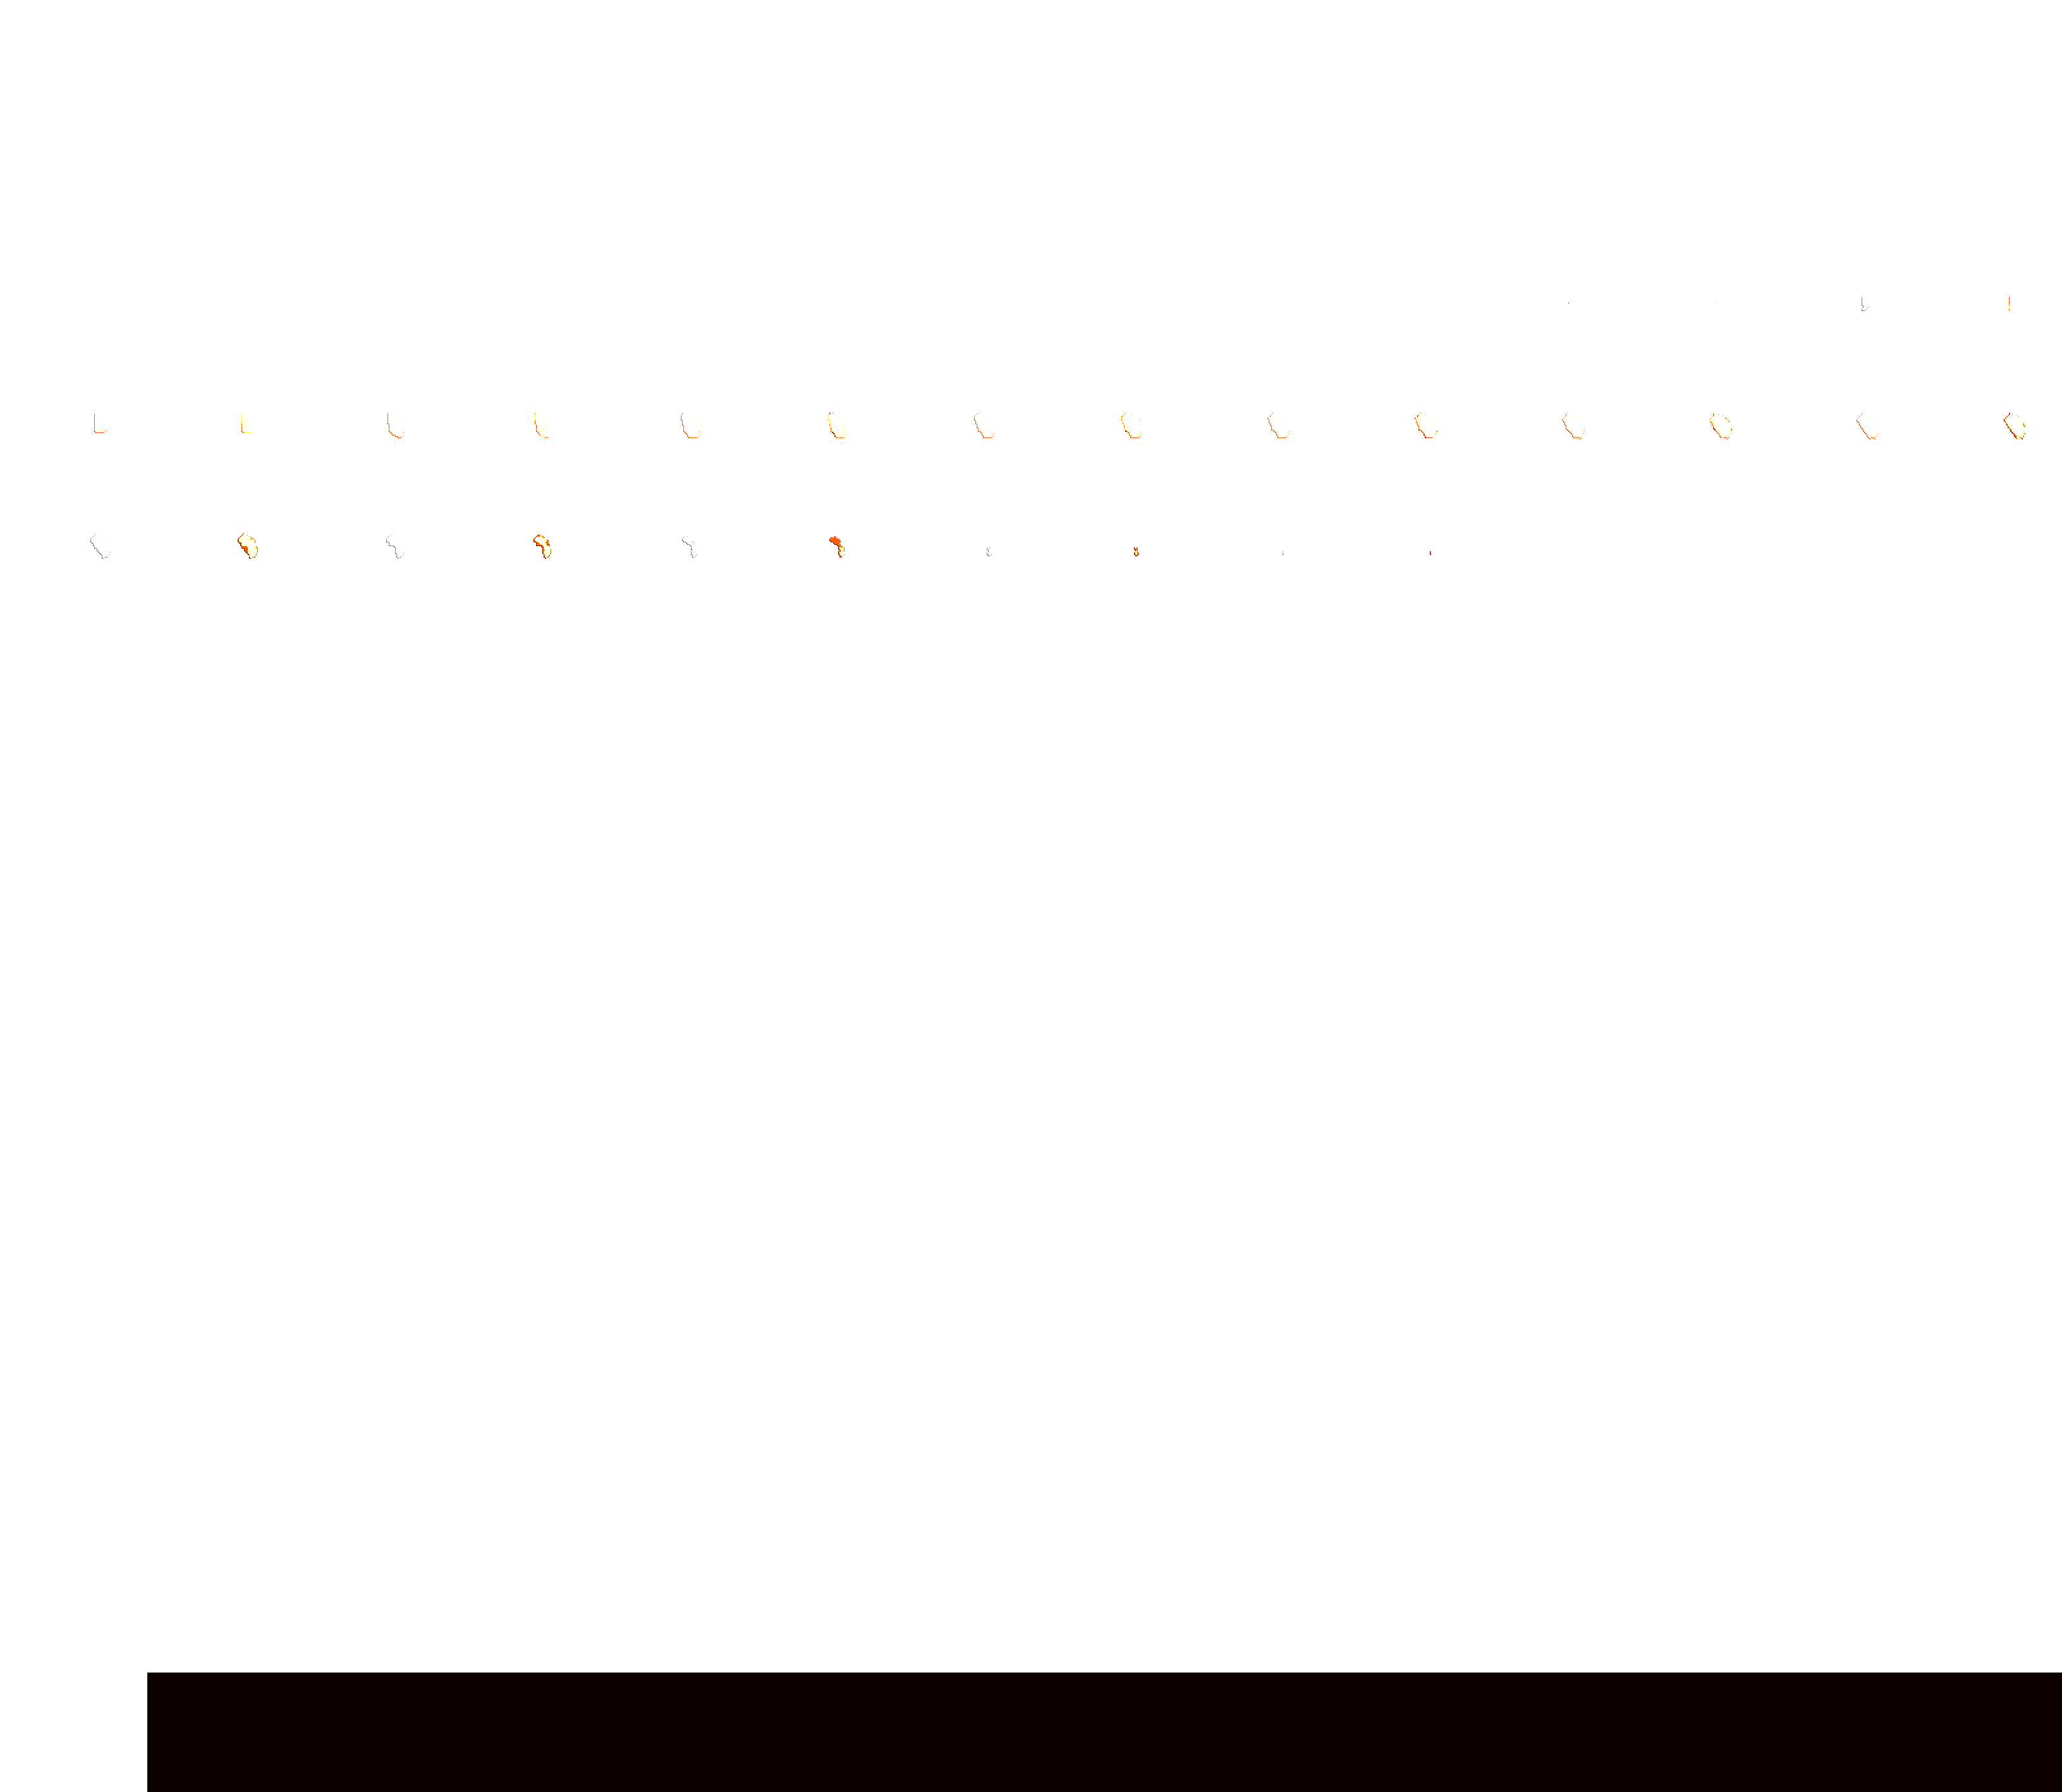

In [119]:
from nilearn.plotting import view_img_on_surf, view_img
view_img(mask_x[45].to_nifti())

In [76]:
Runningman = pd.read_excel(os.path.join(file,'kdrama_April.xlsb.xlsx'), sheet_name = 'Runningman', usecols = ['TRs','cP'])
Runningman = Runningman[0::2] # 1부터 2행마다 
Runningman.drop(Runningman.index[38], axis=0, inplace=True)
Runningman.reset_index(inplace = True, drop = True)
Runningman = Runningman.astype({ 'TRs': 'int', 'cP' : 'float'})

WayToSchool = pd.read_excel(os.path.join(file,'kdrama_April.xlsb.xlsx'), sheet_name = 'WayToSchool', usecols = ['TRs','cP'])
WayToSchool = WayToSchool[0::2] # 1부터 2행마다 
WayToSchool.drop(WayToSchool.index[35], axis=0, inplace=True)
WayToSchool.reset_index(inplace = True, drop = True)
WayToSchool = WayToSchool.astype({ 'TRs': 'int', 'cP' : 'float'})

Neighbors = pd.read_excel(os.path.join(file,'kdrama_April.xlsb.xlsx'), sheet_name = 'Neighbors', usecols = ['TRs','cP'])
Neighbors = Neighbors[0:51:2] # 1부터 2행마다 
#Neighbors.drop(Neighbors.index[26], axis=0, inplace=True)
Neighbors.reset_index(inplace = True, drop = True)
Neighbors = Neighbors.astype({ 'TRs': 'int', 'cP' : 'float'})

BlindDate = pd.read_excel(os.path.join(file,'kdrama_April.xlsb.xlsx'), sheet_name = 'BlindDate', usecols = ['TRs','cP'])
BlindDate = BlindDate[0:101:2] # 1부터 2행마다 
#BlindDate.drop(WayToSchool.index[51], axis=0, inplace=True)
BlindDate.reset_index(inplace = True, drop = True)
BlindDate = BlindDate.astype({ 'TRs': 'int', 'cP' : 'float'})

BusinessLunch = pd.read_excel(os.path.join(file,'kdrama_April.xlsb.xlsx'), sheet_name = 'BusinessLunch', usecols = ['TRs','cP'])
BusinessLunch = BusinessLunch[0:75:2] # 1부터 2행마다 
#BusinessLunch.drop(BusinessLunch.index[38], axis=0, inplace=True)
BusinessLunch.reset_index(inplace = True, drop = True)
BusinessLunch = BusinessLunch.astype({ 'TRs': 'int', 'cP' : 'float'})

t_Runningman = pd.DataFrame()
t_BusinessLunch = pd.DataFrame()
t_Neighbors = pd.DataFrame()
t_WayToSchool = pd.DataFrame()
t_BlindDate = pd.DataFrame()


In [86]:
col = 'cP'
result_average_dynamic = {}

for t in range(Runningman['TRs'].shape[0]):
    encode_time = Runningman['TRs'][t] 

    if t < (Runningman['TRs'].shape[0]-1):
        next_encode_time = Runningman['TRs'][t+1]     
    else:
        next_encode_time = 120

    encode_value = Runningman[col][t]
    column_name = col
    # for loop를 이용한 인코딩
    for i in range(encode_time, next_encode_time):
       #print(range(encode_time, next_encode_time))
       t_Runningman.loc[i, column_name] = encode_value

data = pd.DataFrame(t_Runningman[col]).reset_index(drop = True)
window_average_dynamic = []
for i in range(0, data.shape[0] - window_size + 1, stride):
    window = data.iloc[i:i + window_size]
    average = window.mean() #Same Subject multiple repeat option : exclude_self_corr=True
    window_average_dynamic.append(average[0])
result_average_dynamic['RunningMan'] = pd.Series(window_average_dynamic, index=data.index[window_size - 1:])


t_WayToSchool = pd.DataFrame()
for t in range(WayToSchool['TRs'].shape[0]):
    encode_time = WayToSchool['TRs'][t] 

    if t < (WayToSchool['TRs'].shape[0]-1):
        next_encode_time = WayToSchool['TRs'][t+1]     
    else:
        next_encode_time = 120

    encode_value = WayToSchool[col][t]
    column_name = col
    # for loop를 이용한 인코딩
    for i in range(encode_time, next_encode_time):
       #print(range(encode_time, next_encode_time))
       t_WayToSchool.loc[i, column_name] = encode_value   
        
        
#result_average_dynamic = {}
data = pd.DataFrame(t_WayToSchool[col]).reset_index(drop = True)
window_average_dynamic = []
for i in range(0, data.shape[0] - window_size + 1, stride):
    window = data.iloc[i:i + window_size]
    average = window.mean() #Same Subject multiple repeat option : exclude_self_corr=True
    window_average_dynamic.append(average[0])
result_average_dynamic['WayToSchool'] = pd.Series(window_average_dynamic, index=data.index[window_size - 1:])


for t in range(BlindDate['TRs'].shape[0]):
    encode_time = BlindDate['TRs'][t] 

    if t < (BlindDate['TRs'].shape[0]-1):
        next_encode_time = BlindDate['TRs'][t+1]     
    else:
        next_encode_time = 120

    encode_value = BlindDate[col][t]
    column_name = col
    # for loop를 이용한 인코딩
    for i in range(encode_time, next_encode_time):
       #print(range(encode_time, next_encode_time))
       t_BlindDate.loc[i, column_name] = encode_value

data = pd.DataFrame(t_BlindDate[col]).reset_index(drop = True)
window_average_dynamic = []
for i in range(0, data.shape[0] - window_size + 1, stride):
    window = data.iloc[i:i + window_size]
    window = window * window
    average = window.mean() #Same Subject multiple repeat option : exclude_self_corr=True
    window_average_dynamic.append(average[0])
result_average_dynamic['BlindDate'] = pd.Series(window_average_dynamic, index=data.index[window_size - 1:])

for t in range(BusinessLunch['TRs'].shape[0]):
    encode_time = BusinessLunch['TRs'][t] 

    if t < (BusinessLunch['TRs'].shape[0]-1):
        next_encode_time = BusinessLunch['TRs'][t+1]     
    else:
        next_encode_time = 120

    encode_value = BusinessLunch[col][t]
    column_name = col
    # for loop를 이용한 인코딩
    for i in range(encode_time, next_encode_time):
       #print(range(encode_time, next_encode_time))
       t_BusinessLunch.loc[i, column_name] = encode_value

data = pd.DataFrame(t_BusinessLunch[col]).reset_index(drop = True)
window_average_dynamic = []
for i in range(0, data.shape[0] - window_size + 1, stride):
    window = data.iloc[i:i + window_size]
    window = window * window    
    average = window.mean() #Same Subject multiple repeat option : exclude_self_corr=True
    window_average_dynamic.append(average[0])
result_average_dynamic['BusinessLunch'] = pd.Series(window_average_dynamic, index=data.index[window_size - 1:])

for t in range(Neighbors['TRs'].shape[0]):
    encode_time = Neighbors['TRs'][t] 

    if t < (Neighbors['TRs'].shape[0]-1):
        next_encode_time = Neighbors['TRs'][t+1]     
    else:
        next_encode_time = 120

    encode_value = Neighbors[col][t]
    column_name = col
    # for loop를 이용한 인코딩
    for i in range(encode_time, next_encode_time):
       #print(range(encode_time, next_encode_time))
       t_Neighbors.loc[i, column_name] = encode_value

data = pd.DataFrame(t_Neighbors[col]).reset_index(drop = True)
window_average_dynamic = []
for i in range(0, data.shape[0] - window_size + 1, stride):
    window = data.iloc[i:i + window_size]
    window = window * window
    average = window.mean() #Same Subject multiple repeat option : exclude_self_corr=True
    window_average_dynamic.append(average[0])
result_average_dynamic['Neighbors'] = pd.Series(window_average_dynamic, index=data.index[window_size - 1:])

In [1212]:
WayToSchool = pd.read_excel(os.path.join(file,'kdrama_April.xlsb.xlsx'), sheet_name = 'WayToSchool', usecols = ['TRs','cP'])
WayToSchool = WayToSchool[0::2] # 1부터 2행마다 
WayToSchool.drop(WayToSchool.index[35], axis=0, inplace=True)
WayToSchool.reset_index(inplace = True, drop = True)
WayToSchool = WayToSchool.astype({ 'TRs': 'int', 'cP' : 'float'})

In [1213]:
t_WayToSchool = pd.DataFrame()
for t in range(WayToSchool['TRs'].shape[0]):
    encode_time = WayToSchool['TRs'][t] 

    if t < (WayToSchool['TRs'].shape[0]-1):
        next_encode_time = WayToSchool['TRs'][t+1]     
    else:
        next_encode_time = 120

    encode_value = WayToSchool[col][t]
    column_name = col
    # for loop를 이용한 인코딩
    for i in range(encode_time, next_encode_time):
       #print(range(encode_time, next_encode_time))
       t_WayToSchool.loc[i, column_name] = encode_value   
        
        
#result_average_dynamic = {}
data = pd.DataFrame(t_WayToSchool[col]).reset_index(drop = True)
window_average_dynamic = []
for i in range(0, data.shape[0] - window_size + 1, stride):
    window = data.iloc[i:i + window_size]
    average = window.mean() #Same Subject multiple repeat option : exclude_self_corr=True
    window_average_dynamic.append(average[0])
result_average_dynamic['Way To School'] = pd.Series(window_average_dynamic, index=data.index[window_size - 1:])

In [1215]:
result_average_dynamic['Way To School']
t_WayToSchool.loc[:,'cP']

10     0.00
11     0.00
12     0.00
13     0.00
14     0.00
       ... 
115   -0.25
116   -0.25
117   -0.25
118   -0.25
119   -0.25
Name: cP, Length: 110, dtype: float64

# Plotting Dynamic Counting

## Load Dynamic Counting

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
import glob

file_dir = glob.glob(os.path.join('/mnt/c/Users/since/Desktop/Recall/Rubrics/KClips/2023_fMRI_April'))
#glob.glob(os.path.join(fmriprep_dir,'sub-01','anat', '*preproc_T1w.nii.gz'))
file = file_dir[0]
print(file)

/mnt/c/Users/since/Desktop/Recall/Rubrics/KClips/2023_fMRI_April


In [3]:
#Load Stories

Runningman = pd.read_excel(os.path.join(file,'kdrama_timeline_April.xlsx'), sheet_name = 'Runningman', usecols = ['TRs', 'S1-1', 'S1-2', 'S2-1', 'S2-2', 'S3-1', 'S3-2', 'S4-1', 'S4-2', 'S8-1', 'S8-2'])
BusinessLunch = pd.read_excel(os.path.join(file,'kdrama_timeline_April.xlsx'), sheet_name = 'Business', usecols = ['TRs', 'S1-1', 'S1-2', 'S2-1', 'S2-2', 'S3-1', 'S3-2', 'S4-1', 'S4-2', 'S8-1', 'S8-2'])

Neighbors = pd.read_excel(os.path.join(file,'kdrama_timeline_April.xlsx'), sheet_name = 'Neighbors', usecols = ['TRs', 'S1-1', 'S1-2','S3-1', 'S3-2', 'S4-1', 'S4-2', 'S8-1', 'S8-2'])
WayToSchool = pd.read_excel(os.path.join(file,'kdrama_timeline_April.xlsx'), sheet_name = 'WayToSchool', usecols = ['TRs', 'S1-1', 'S1-2', 'S3-1', 'S3-2', 'S4-1', 'S4-2', 'S8-1', 'S8-2'])
BlindDate = pd.read_excel(os.path.join(file,'kdrama_timeline_April.xlsx'), sheet_name = 'BlindDate', usecols = ['TRs', 'S1-1', 'S1-2', 'S3-1', 'S3-2', 'S4-1', 'S4-2', 'S8-1', 'S8-2'])

In [11]:
#Runningman
Runningman = Runningman.fillna(0.0)
Runningman.reset_index(inplace = True, drop=True)
#Runningman.drop(Runningman.index[38], axis=0, inplace=True)
Runningman = Runningman.astype({'S1-1': 'float', 'S1-2': 'float', 'S3-1': 'float', 'S3-2': 'float', 'S4-1': 'float', 'S4-2': 'float', 'S8-1': 'float', 'S8-2': 'float'})

for sub in ['S1', 'S3', 'S4', 'S8']:
    Runningman[f'{sub}_Change'] = Runningman[f'{sub}-2'] - Runningman[f'{sub}-1'] 
    Runningman[f'{sub}_OnOff'] = Runningman[f'{sub}-2'] + Runningman[f'{sub}-1'] 
    Runningman[f'{sub}_Both'] = Runningman[f'{sub}_OnOff'] *  Runningman[f'{sub}_Change']
Runningman = Runningman.astype({ 'S1_Change' : 'float', 'S3_Change': 'float', 'S4_Change': 'float', 'S8_Change': 'float'})
Runningman = Runningman.astype({ 'S1_OnOff' : 'float', 'S3_OnOff': 'float', 'S4_OnOff': 'float', 'S8_OnOff': 'float'})
Runningman = Runningman.astype({ 'S1_Both' : 'float', 'S3_Both': 'float', 'S4_Both': 'float', 'S8_Both': 'float'})

#BusinessLunch
BusinessLunch = BusinessLunch.fillna(0.0)
BusinessLunch.reset_index(inplace = True, drop=True)
#BusinessLunch.drop(BusinessLunch.index[37], axis=0, inplace=True)
BusinessLunch = BusinessLunch.astype({'S1-1': 'float', 'S1-2': 'float', 'S3-1': 'float', 'S3-2': 'float', 'S4-1': 'float', 'S4-2': 'float', 'S8-1': 'float', 'S8-2': 'float'})

# for sub in ['S1', 'S2', 'S3', 'S4', 'S8']:
#     BusinessLunch[f'{sub}_Change'] = BusinessLunch[f'{sub}-2'] - BusinessLunch[f'{sub}-1'] 
# BusinessLunch = BusinessLunch.astype({ 'S1_Change' : 'float', 'S2_Change': 'float', 'S3_Change': 'float', 'S4_Change': 'float', 'S8_Change': 'float'})

#Neighbors
# Neighbors = Neighbors.fillna(0.0)
# Neighbors.reset_index(inplace = True, drop=True)
# Neighbors.drop(Neighbors.index[30], axis=0, inplace=True)
# Neighbors = Neighbors.astype({'S1-1': 'float', 'S1-2': 'float', 'S3-1': 'float', 'S3-2': 'float', 'S4-1': 'float', 'S4-2': 'float', 'S8-1': 'float', 'S8-2': 'float'})

# for sub in ['S1', 'S3', 'S4', 'S8']:
#     Neighbors[f'{sub}_Change'] = Neighbors[f'{sub}-2'] - Neighbors[f'{sub}-1'] 
# Neighbors = Neighbors.astype({ 'S1_Change' : 'float', 'S3_Change': 'float', 'S4_Change': 'float', 'S8_Change': 'float'})

#WayToSchool
# WayToSchool = WayToSchool.fillna(0.0)
# WayToSchool.reset_index(inplace = True, drop=True)
#WayToSchool.drop(WayToSchool.index[35], axis=0, inplace=True)

# for sub in ['S1', 'S3', 'S4', 'S8']:
#     WayToSchool[f'{sub}_Change'] = WayToSchool[f'{sub}-2'] - WayToSchool[f'{sub}-1'] 
# WayToSchool = WayToSchool.astype({ 'TRs': 'int', 'S1_Change' : 'float', 'S3_Change': 'float', 'S4_Change': 'float', 'S8_Change': 'float'})

#BlindDate
# BlindDate = BlindDate.fillna(0.0)
# BlindDate.reset_index(inplace = True, drop=True)
# BlindDate.drop(BlindDate.index[55], axis=0, inplace=True)
# BlindDate = BlindDate.astype({'S1-1': 'float', 'S1-2': 'float', 'S3-1': 'float', 'S3-2': 'float', 'S4-1': 'float', 'S4-2': 'float', 'S8-1': 'float', 'S8-2': 'float'})

# for sub in ['S1', 'S3', 'S4', 'S8']:
#     BlindDate[f'{sub}_Change'] = BlindDate[f'{sub}-2'] - BlindDate[f'{sub}-1'] 
# BlindDate = BlindDate.astype({ 'S1_Change' : 'float', 'S3_Change': 'float', 'S4_Change': 'float', 'S8_Change': 'float'})

In [12]:
t_Runningman = pd.DataFrame()
t_Neighbors = pd.DataFrame()
t_BlindDate = pd.DataFrame()
#t_BusinessLunch = pd.DataFrame()
#t_WayToSchool = pd.DataFrame()

#column_names = ['S1_Change', 'S2_Change', 'S3_Change', 'S4_Change', 'S8_Change']
column_names = ['S1-1', 'S1-2', 'S3-1', 'S3-2', 'S4-1', 'S4-2', 'S1_Change', 'S3_Change', 'S4_Change', 'S1_OnOff', 'S3_OnOff', 'S4_OnOff', 'S1_Both', 'S3_Both', 'S4_Both', 'S8_Both']
#Runningman 
for col in column_names:
    for t in range(Runningman['TRs'].shape[0]):
        encode_time = Runningman['TRs'][t] 

        if t < (Runningman['TRs'].shape[0]-1):
            next_encode_time = Runningman['TRs'][t+1]     
        else:
            next_encode_time = 126

        encode_value = Runningman[col][t]
        #print(encode_value)
        column_name = col
        # for loop를 이용한 인코딩
        for i in range(encode_time, next_encode_time):
           #print(range(encode_time, next_encode_time))
           t_Runningman.loc[i, column_name] = encode_value

In [18]:
t_Runningman = t_Runningman.astype({'S1-1': 'float', 'S1-2': 'float', 'S3-1': 'float', 'S3-2': 'float', 'S4-1': 'float', 'S4-2': 'float'})
t_Runningman = t_Runningman.astype({ 'S1_Change' : 'float', 'S3_Change': 'float', 'S4_Change': 'float'})
t_Runningman = t_Runningman.astype({ 'S1_OnOff' : 'float', 'S3_OnOff': 'float', 'S4_OnOff': 'float'})
t_Runningman = t_Runningman.astype({ 'S1_Both' : 'float', 'S3_Both': 'float', 'S4_Both': 'float'})
t_Runningman['S3_Both']

10     1.0
11     1.0
12     1.0
13     1.0
14     0.0
      ... 
121    0.0
122    0.0
123    0.0
124    0.0
125    0.0
Name: S3_Both, Length: 116, dtype: float64

In [75]:
t_Runningman = pd.DataFrame()
t_Neighbors = pd.DataFrame()
t_BlindDate = pd.DataFrame()
#t_BusinessLunch = pd.DataFrame()
#t_WayToSchool = pd.DataFrame()

#column_names = ['S1_Change', 'S2_Change', 'S3_Change', 'S4_Change', 'S8_Change']
column_names = ['S1-1', 'S1-2', 'S3-1', 'S3-2', 'S4-1', 'S4-2']
#Runningman 
for col in column_names:
    for t in range(Runningman['TRs'].shape[0]):
        encode_time = Runningman['TRs'][t] 

        if t < (Runningman['TRs'].shape[0]-1):
            next_encode_time = Runningman['TRs'][t+1]     
        else:
            next_encode_time = 116

        encode_value = Runningman[col][t]
        print(encode_value)
        column_name = col
        # for loop를 이용한 인코딩
        for i in range(encode_time, next_encode_time):
           #print(range(encode_time, next_encode_time))
           t_Runningman.loc[i, column_name] = encode_value
#Neighbors
for col in column_names:
    for t in range(Neighbors['TRs'].shape[0]):
        encode_time = int(Neighbors['TRs'][t]) 

        if t < (Neighbors['TRs'].shape[0]-1):
            next_encode_time = int(Neighbors['TRs'][t+1])    
        else:
            next_encode_time = 116

        encode_value = Neighbors[col][t]
        column_name = col
        # for loop를 이용한 인코딩
        for i in range(encode_time, next_encode_time):
           #print(range(encode_time, next_encode_time))
           t_Neighbors.loc[i, column_name] = encode_value            
            
# BlindDate
for col in column_names:
    for t in range(BlindDate['TRs'].shape[0]):
        encode_time = int(BlindDate['TRs'][t]) 

        if t < (BlindDate['TRs'].shape[0]-1):
            next_encode_time = int(BlindDate['TRs'][t+1])    
        else:
            next_encode_time = 116

        encode_value = BlindDate[col][t]
        column_name = col
        # for loop를 이용한 인코딩
        for i in range(encode_time, next_encode_time):
           #print(range(encode_time, next_encode_time))
           t_BlindDate.loc[i, column_name] = encode_value   
            
# WayToSchool
# for col in column_names2:
#     for t in range(WayToSchool['TRs'].shape[0]):
#         encode_time = WayToSchool['TRs'][t] 

#         if t < (WayToSchool['TRs'].shape[0]-1):
#             next_encode_time = WayToSchool['TRs'][t+1]     
#         else:
#             next_encode_time = 120

#         encode_value = WayToSchool[col][t]
#         column_name = col
#         # for loop를 이용한 인코딩
#         for i in range(encode_time, next_encode_time):
#            #print(range(encode_time, next_encode_time))
#            t_WayToSchool.loc[i, column_name] = encode_value   

            
#BusinessLunch
# for col in column_names:
#     for t in range(BusinessLunch['TRs'].shape[0]):
#         encode_time = BusinessLunch['TRs'][t] 

#         if t < (BusinessLunch['TRs'].shape[0]-1):
#             next_encode_time = BusinessLunch['TRs'][t+1]     
#         else:
#             next_encode_time = 120

#         encode_value = BusinessLunch[col][t]
#         column_name = col
#         # for loop를 이용한 인코딩
#         for i in range(encode_time, next_encode_time):
#            #print(range(encode_time, next_encode_time))
#            t_BusinessLunch.loc[i, column_name] = encode_value

#column_names2 = ['S1_Change', 'S3_Change', 'S4_Change', 'S8_Change']   

timeseries = {'BlindDate' : t_BlindDate, 'Neighbors': t_Neighbors, 'Runningman' : t_Runningman}


0.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
0.0
1.0
0.0
1.0
0.0


In [37]:
#Sliding window for corr between First and Second Recall 
 
# 슬라이딩 타임 윈도우 크기 및 간격 설정
window_size = 30 #45secs 
stride = 1  # 윈도우 이동 간격 (TR 단위)

sub_sliding_behav_r = {}
sub_sliding_behav_p = {}
for sub in ['1', '3', '4']:
    sliding_r = {}
    sliding_p = {}
    data = pd.DataFrame()
    #for story in ['BlindDate', 'Neighbors', 'Runningman']:
    data[f'S{sub}-1'] = pd.DataFrame(t_Runningman[f'S{sub}-1']).reset_index(drop = True)
    data[f'S{sub}-2'] = pd.DataFrame(t_Runningman[f'S{sub}-2']).reset_index(drop = True)
    print(data)
    window_isc_r = []
    window_isc_p = []
    for i in range(0, data.shape[0] - window_size + 1, stride):
        window = data.iloc[i:i + window_size]
        stats = isc(window, n_bootstraps=5000, metric='median', method='bootstrap', exclude_self_corr=True) #Same Subject multiple repeat option : exclude_self_corr=True
        window_isc_r.append(stats['isc'])
        window_isc_p.append(stats['p'])
    result_r = pd.Series(window_isc_r, index=data.index[window_size - 1:])
    result_p = pd.Series(window_isc_p, index=data.index[window_size - 1:])
    #sliding_r['Runningman'] = result_r
    #sliding_p['Runningman'] = result_p
    #sub_sliding_behav_r[sub] = sliding_r
    #sub_sliding_behav_p[sub] = sliding_p
    sub_sliding_behav_r[sub] = result_r
    sub_sliding_behav_p[sub] = result_p


     S1-1  S1-2
0     0.0   1.0
1     0.0   1.0
2     0.0   1.0
3     0.0   1.0
4     0.0   0.0
..    ...   ...
111   0.0   0.0
112   0.0   0.0
113   0.0   0.0
114   0.0   0.0
115   0.0   0.0

[116 rows x 2 columns]
     S3-1  S3-2
0     0.0   1.0
1     0.0   1.0
2     0.0   1.0
3     0.0   1.0
4     0.0   0.0
..    ...   ...
111   0.0   0.0
112   0.0   0.0
113   0.0   0.0
114   0.0   0.0
115   0.0   0.0

[116 rows x 2 columns]
     S4-1  S4-2
0     1.0   1.0
1     1.0   1.0
2     1.0   1.0
3     1.0   1.0
4     0.0   0.0
..    ...   ...
111   0.0   0.0
112   0.0   0.0
113   0.0   0.0
114   0.0   0.0
115   0.0   0.0

[116 rows x 2 columns]


In [38]:
#Sliding window for corr between First and Second Recall 
import statsmodels.api as sm 
# 슬라이딩 타임 윈도우 크기 및 간격 설정
window_size = 30 #45secs 
stride = 1  # 윈도우 이동 간격 (TR 단위)

sub_sliding_change_r = {}
sub_sliding_change_r2 = {}
sub_sliding_change_p = {}
for sub in ['1', '3', '4']:
    sliding_r = {}
    sliding_p = {}
    data = pd.DataFrame()
    #for story in ['BlindDate', 'Neighbors', 'Runningman']:
    data = (t_Runningman[f'S{sub}_Change']).reset_index(drop = True)
    #print(data)
    window_smoothed = []
    window_smoothed2 = []
    for i in range(0, data.shape[0] - window_size + 1, stride):
        window = data.iloc[i:i + window_size]
        x = np.linspace(0,30,30)
        lowess = sm.nonparametric.lowess(window, x, frac=0.2)
        smoothed_y = lowess[:, 1]
        window_smoothed.append(sum(smoothed_y))
        window_smoothed2.append(sum(window))
    sub_sliding_change_r[sub] = pd.Series(window_smoothed, index=data.index[window_size - 1:])
    sub_sliding_change_r2[sub] = pd.Series(window_smoothed2, index=data.index[window_size - 1:])


In [31]:
#Sliding window for corr between First and Second Recall 
 
# 슬라이딩 타임 윈도우 크기 및 간격 설정
window_size = 30 #45secs 
stride = 1  # 윈도우 이동 간격 (TR 단위)

sub_sliding_Both_r = {}
sub_sliding_Both_r2 = {}
#sub_sliding_change_p = {}
for sub in ['1', '3', '4']:
    sliding_r = {}
    sliding_p = {}
    data = pd.DataFrame()
    #for story in ['BlindDate', 'Neighbors', 'Runningman']:
    data = (t_Runningman[f'S{sub}_Both']).reset_index(drop = True)
    #print(data)
    window_smoothed = []
    window_smoothed2 = []
    for i in range(0, data.shape[0] - window_size + 1, stride):
        window = data.iloc[i:i + window_size]
        x = np.linspace(0,30,30)
        lowess = sm.nonparametric.lowess(window, x, frac=0.2)
        smoothed_y = lowess[:, 1]
        window_smoothed.append(sum(smoothed_y))
        window_smoothed2.append(sum(window))
    sub_sliding_Both_r[sub] = pd.Series(window_smoothed, index=data.index[window_size - 1:])
    sub_sliding_Both_r2[sub] = pd.Series(window_smoothed2, index=data.index[window_size - 1:])


In [289]:
smoothed_y[:][:]

array([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Smoothing Change Scores with local regression 

In [113]:
cd EncodingTask/AV_Corr

/home/sincerely/jupyterlab/Movie-encoding/fMRI01/EncodingTask/AV_Corr


In [118]:
import pickle
with open('slinding_corr_r_0511.pickle', 'rb') as f:
    ZROIs = pickle.load(f)
ZROIs[28]['1']['RunningMan']

29    -0.060988
30    -0.054788
31    -0.036099
32    -0.014952
33    -0.024029
         ...   
110   -0.271493
111   -0.163113
112   -0.123775
113   -0.042224
114   -0.007234
Length: 86, dtype: float64

## Plot sliding dynamic behavs of all subject 

In [32]:
Runningman_event_TR = [24, 42, 53, 97]

In [34]:
import pickle
with open("slinding_behav_0608.pickle","wb") as fw:
    pickle.dump(sub_sliding_behav_r, fw)
with open("slinding_change_0608.pickle","wb") as fw:
    pickle.dump(sub_sliding_change_r, fw)

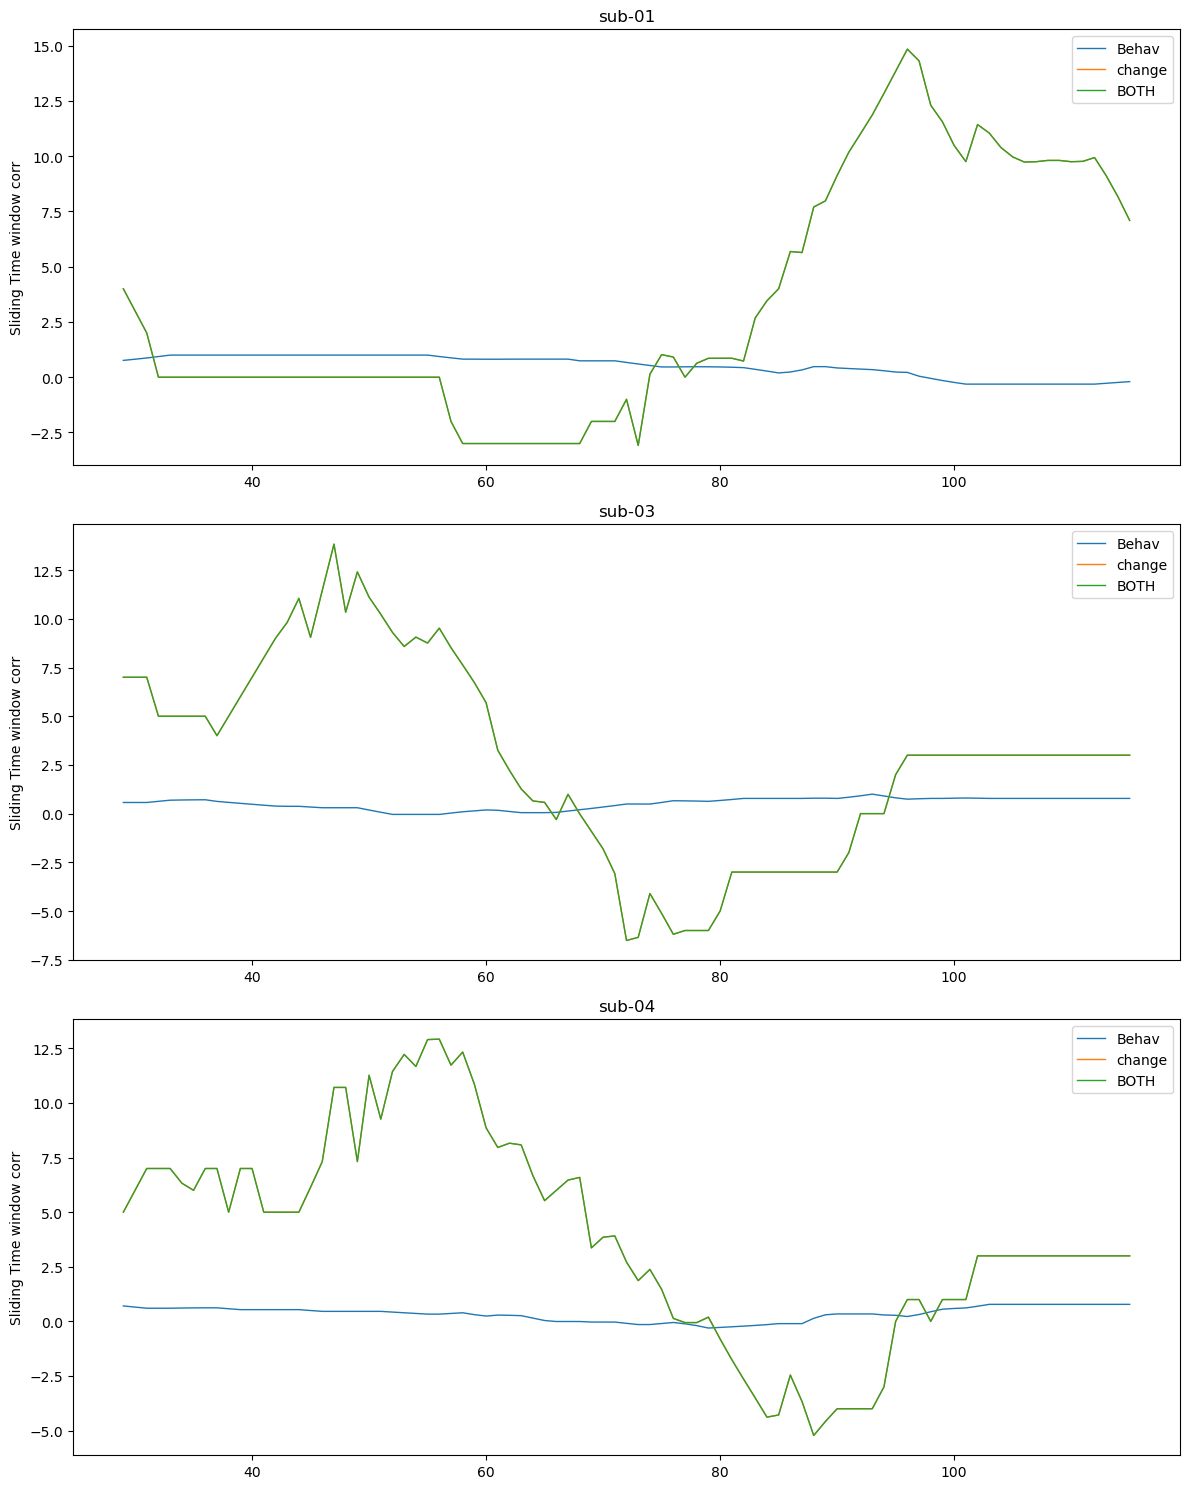

/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()
/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1120: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()
/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1120: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.7 support is deprecated and w

In [43]:
Runningman_event_TR = [24, 42, 53, 97]

palette = ['darkseagreen', 'darkgray', 'rosybrown', 'dimgrey', 'lightslategray', 'lightsteelblue', 'cadetblue','silver']
import seaborn as sns



fig, axes = plt.subplots(3, 1, figsize = (12,15))     
#for position, sub in enumerate(['1','3','4']):  
for num, sub in enumerate(['1','3','4']):  
    squred_change = t_Runningman[f'S{sub}_Change']* t_Runningman[f'S{sub}_Change']
    axes[num].plot(pd.DataFrame(sub_sliding_behav_r[sub]), linewidth= 1, label = 'Behav' )
    axes[num].plot(pd.DataFrame(sub_sliding_change_r[sub]), linewidth= 1, label = 'change' )
    axes[num].plot(pd.DataFrame(sub_sliding_Both_r[sub]), linewidth= 1, label = 'BOTH' )
    #axes[num].plot(squred_change*0.5, linestyle = 'dashed', color='red', label='**2 Data')
    #axes[num].plot(pd.DataFrame(sub_sliding_change_r[sub])*0.1, linestyle = 'dashed', color='Gray', linewidth= 0.5, label='Change Score')
    #axes[num].fill_between(sub_sliding_change_r[sub].index, 0.0, sub_sliding_change_r[sub][:]*0.1, color='lightgray', alpha=0.5, label='Change Score')
    #axes[num].fill_between(sub_sliding_Both_r[sub].index, 0.0, sub_sliding_Both_r[sub][:]*0.1, color='lightblue', alpha=0.5, label='Both Score')
    #axes[num].fill_between(sub_sliding_change_r2[sub].index, 0.0, sub_sliding_change_r[sub][:]*0.1, color='lightgray', alpha=0.5, label='Change Score')
    #axes[num].plot(pd.DataFrame(ZROIs[5][sub]['RunningMan']), color = 'blue', linestyle = '--', linewidth= 1.5, label = 'TPJ' )
    #axes[num].plot(pd.DataFrame(ZROIs[32][sub]['RunningMan']), color = 'Orange', linestyle = '--', linewidth= 1, label = f'sub-0{sub} PCC' )
    #axes[num].plot(pd.DataFrame(ZROIs[19][sub]['RunningMan']), color = 'green', linestyle = '--', linewidth= 1, label = f'sub-0{sub} PCC/LOC' )
    #axes[num].axhline(0.0, 0, 1.0, color='lightgray', linestyle='solid', linewidth=1)
    #axes[num].axhline(-0.75, (Runningman_event_TR[0]-29)/87+0.1, (Runningman_event_TR[1]-29)/87, color='lightblue', linestyle='solid', linewidth=20)
    #axes[num].axhline(-0.75, (Runningman_event_TR[1]-29)/87, (Runningman_event_TR[2]-29)/87, color='lightgreen', linestyle='solid', linewidth=20)
    #axes[num].axhline(-0.75, (Runningman_event_TR[2]-29)/87, (Runningman_event_TR[3]-29)/87, color='purple', linestyle='solid', linewidth=20)
    #axes[num].axhline(-0.75, (Runningman_event_TR[3]-29)/87,  0.9, linestyle='solid', linewidth=20)
    axes[num].set_title(f"sub-0{sub}")
    axes[num].set_ylabel("Sliding Time window corr")
    axes[num].legend()

#plt.title("Behavior corr for Runningman", fontsize = 25)
fig.tight_layout()
plt.show()
#fig.savefig('Compare behave socres.png')

## Get Pearson's P between behav and ROI 

In [409]:
mean_hpc = []
mean_tpj = []
mean_pcc = []
print('correlation behav_STW and ROI_STW')
for sub in ['1','3','4']:  
    corr_coef_hpc = sub_sliding_behav_r[sub].corr(ZROIs[28][sub]['RunningMan'])
    corr_coef_tpj = sub_sliding_behav_r[sub].corr(ZROIs[5][sub]['RunningMan'])
    corr_coef_pcc = sub_sliding_behav_r[sub].corr(ZROIs[6][sub]['RunningMan'])
    corr_coef_vmpfc = sub_sliding_behav_r[sub].corr(ZROIs[32][sub]['RunningMan'])
    mean_hpc.append(corr_coef_hpc)
    mean_tpj.append(corr_coef_tpj)
    mean_pcc.append(corr_coef_pcc)
    print(f'sub-0{sub} behav-ROI corr: HPC', round(corr_coef_hpc,3), ', TPJ', round(corr_coef_tpj,3), ', PCC', round(corr_coef_pcc,3), ', vmPFC ',round(corr_coef_vmPFC,3))
    #print(f'{sub} behav-ROI p_value: HPC', round(p_vlaue_hpc,3), ' PCC ', round(p_vlaue_pcc,3), ' PCC2 ', round(p_vlaue_pcc2,3), ' vmPFC ',round(p_vlaue_vmPFC,3))
print(f'Mean of ChangesScores-ROI Corr: HPC', round(np.mean(mean_hpc),3), ', TPJ',  round(np.mean(mean_tpj),3), ', PCC',  round(np.mean(mean_pcc),3))


correlation behav_STW and ROI_STW
sub-01 behav-ROI corr: HPC 0.521 , TPJ -0.501 , PCC -0.815 , vmPFC  -0.148
sub-03 behav-ROI corr: HPC 0.498 , TPJ 0.433 , PCC 0.822 , vmPFC  -0.148
sub-04 behav-ROI corr: HPC -0.328 , TPJ -0.597 , PCC 0.379 , vmPFC  -0.148
Mean of ChangesScores-ROI Corr: HPC 0.23 , TPJ -0.222 , PCC 0.128


In [411]:
mean_hpc = []
mean_tpj = []
mean_pcc = []
print('correlation Change_STW and ROI_STW')
for sub in ['1','3','4']:  
    corr_coef_hpc = sub_sliding_change_r[sub].corr(ZROIs[28][sub]['RunningMan'])
    corr_coef_tpj = sub_sliding_change_r[sub].corr(ZROIs[5][sub]['RunningMan'])
    corr_coef_pcc = sub_sliding_change_r[sub].corr(ZROIs[6][sub]['RunningMan'])
    corr_coef_vmpfc = sub_sliding_change_r[sub].corr(ZROIs[32][sub]['RunningMan'])
    mean_hpc.append(corr_coef_hpc)
    mean_tpj.append(corr_coef_tpj)
    mean_pcc.append(corr_coef_pcc)
    print(f'sub-0{sub} ChangeScores-ROI corr: HPC', round(corr_coef_hpc,3), ', TPJ', round(corr_coef_tpj,3), ', PCC', round(corr_coef_pcc,3), ', vmPFC ',round(corr_coef_vmPFC,3))
print(f'Mean of ChangesScores-ROI Corr: HPC', round(np.mean(mean_hpc),3), ', TPJ',  round(np.mean(mean_tpj),3), ', PCC',  round(np.mean(mean_pcc),3))
    #print(f'{sub} behav-ROI p_value: HPC', round(p_vlaue_hpc,3), ' PCC ', round(p_vlaue_pcc,3), ' PCC2 ', round(p_vlaue_pcc2,3), ' vmPFC ',round(p_vlaue_vmPFC,3))

correlation Change_STW and ROI_STW
sub-01 ChangeScores-ROI corr: HPC -0.646 , TPJ 0.562 , PCC 0.851 , vmPFC  -0.148
sub-03 ChangeScores-ROI corr: HPC -0.87 , TPJ -0.825 , PCC -0.215 , vmPFC  -0.148
sub-04 ChangeScores-ROI corr: HPC 0.565 , TPJ 0.407 , PCC 0.718 , vmPFC  -0.148
Mean of ChangesScores-ROI Corr: HPC -0.317 , TPJ 0.048 , PCC 0.451


In [425]:
mean_corr = []
print('correlation Change_STW and ROI_STW')
for sub in ['1','3','4']:  
    corr_coef = sub_sliding_change_r[sub].corr(sub_sliding_behav_r[sub])
    print(f'sub-0{sub} corr: ', round(corr_coef,2))
    mean_corr.append(corr_coef)
print('Subjects mean corr', round(np.mean(mean_corr),2))
    #print(f'{sub} behav-ROI p_value: HPC', round(p_vlaue_hpc,3), ' PCC ', round(p_vlaue_pcc,3), ' PCC2 ', round(p_vlaue_pcc2,3), ' vmPFC ',round(p_vlaue_vmPFC,3))

correlation Change_STW and ROI_STW
sub-01 corr:  -0.82
sub-03 corr:  -0.45
sub-04 corr:  0.34
Subjects mean corr -0.31


## plot for story * subject 

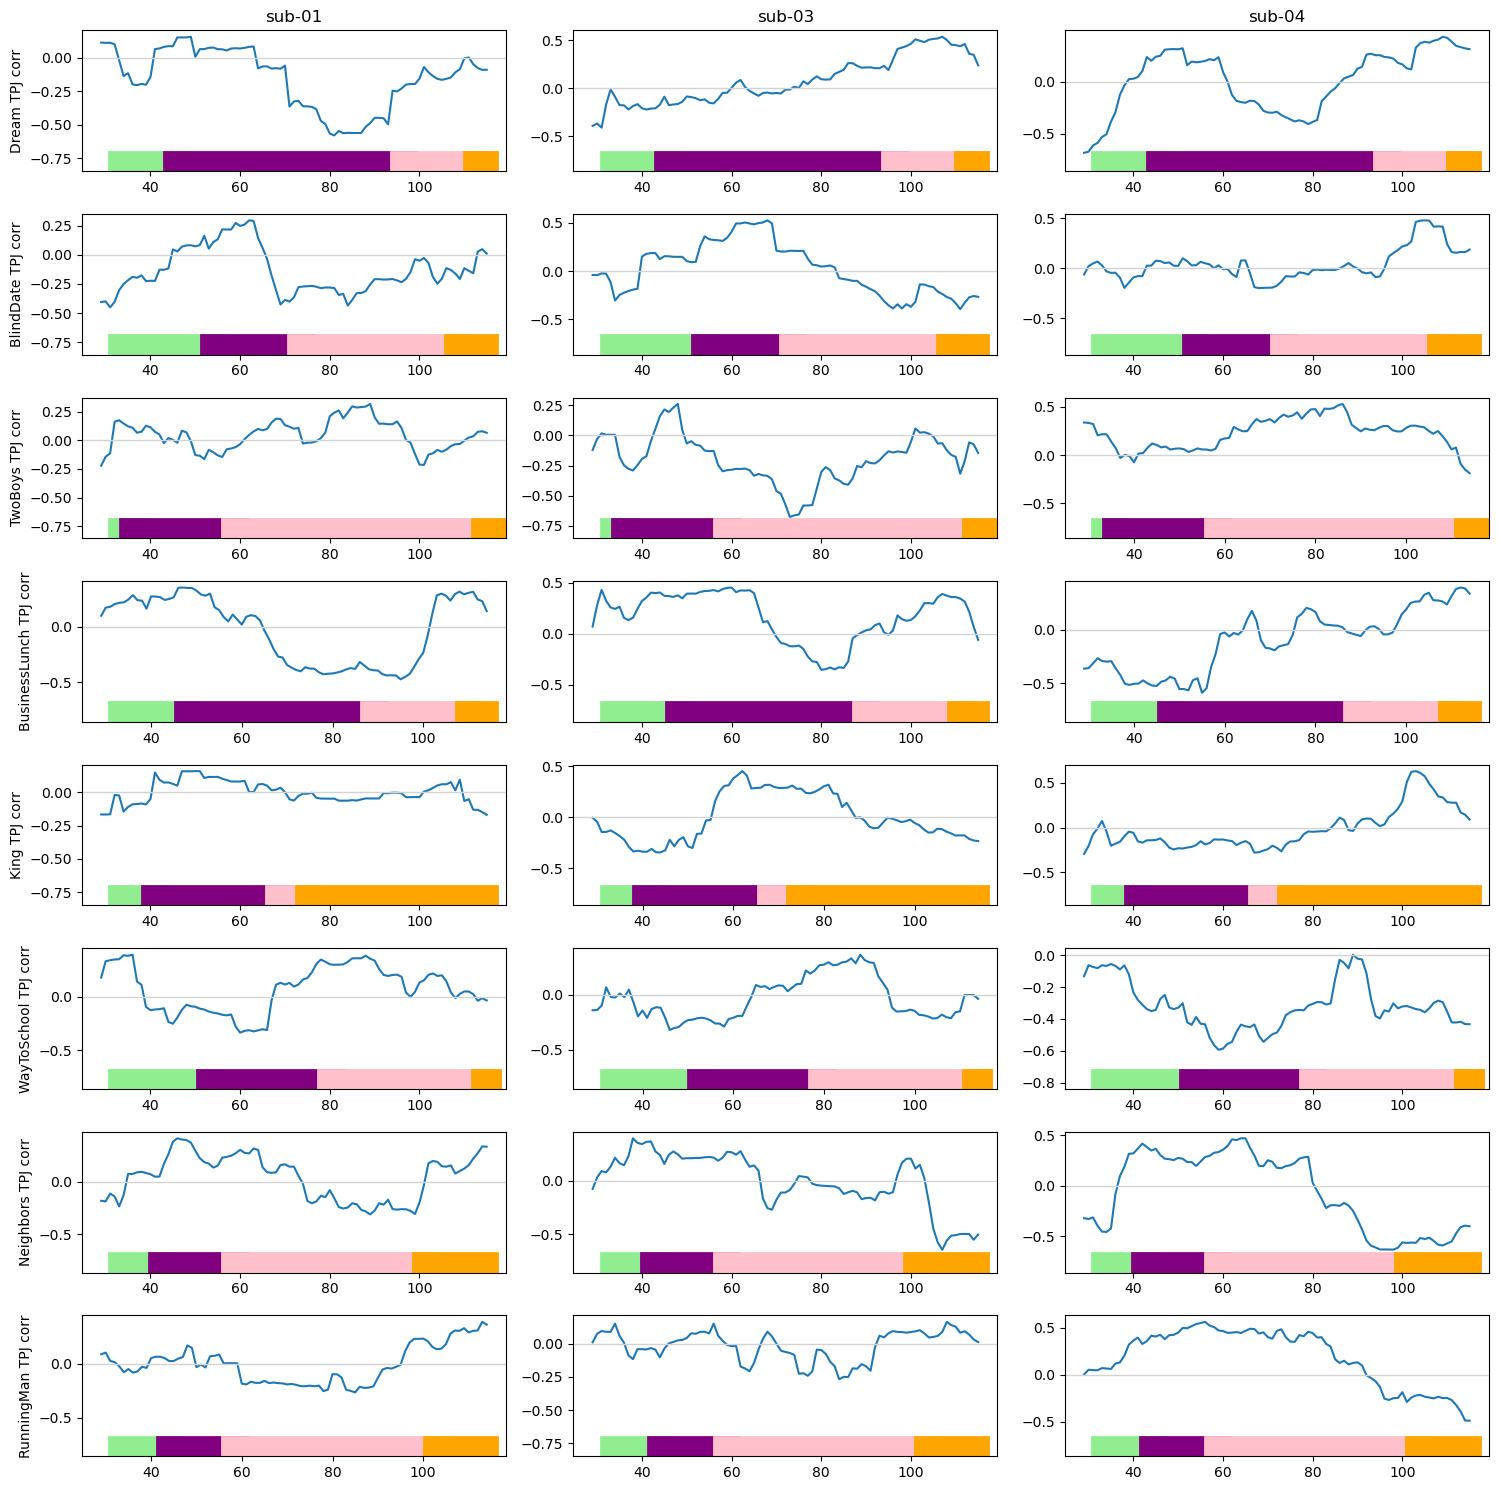

In [395]:
fig, axes = plt.subplots(8, 3, figsize = (15,15))     
#for position, sub in enumerate(['1','3','4']):  
for position, sub in enumerate(['1','3','4']):  
    for num in np.arange(all_story['1'].shape[0]):
        story = all_story['1'][num]
        axes[num, position].plot(pd.DataFrame(All_sliding_r[5][sub][story]))
        axes[0, position].set_title(f"sub-0{sub}")
        axes[num, 0].set_ylabel(f"{story} TPJ corr")
        axes[num, position].axhline(0.0, 0, 1.0, color='lightgray', linestyle='solid', linewidth=1)
        #plt.axhline(1.0, 11/110,Runningman_event_TR[0]/110,color='lightgray', linestyle='solid', linewidth=20)
        # axes[num, position].axhline(-0.8, 0.05,  story_TR[story][0]/116, color='lightblue', linestyle='solid', linewidth=20)
        axes[num, position].axhline(-0.8,  story_TR[story][0]/116, story_TR[story][1]/116, color='lightgreen', linestyle='solid', linewidth=20)
        axes[num, position].axhline(-0.8,  story_TR[story][1]/116, story_TR[story][2]/116, color='purple', linestyle='solid', linewidth=20)
        axes[num, position].axhline(-0.8,  story_TR[story][2]/116, story_TR[story][3]/116, color='pink', linestyle='solid', linewidth=20)
        axes[num, position].axhline(-0.8,  story_TR[story][3]/116,  0.95, color='orange', linestyle='solid',linewidth=20)
fig.tight_layout()
#axes[, 4].set_xlabel("30 TRs Window")
plt.show()
fig.savefig('roi-5_TPJ_S0[1-3].png')

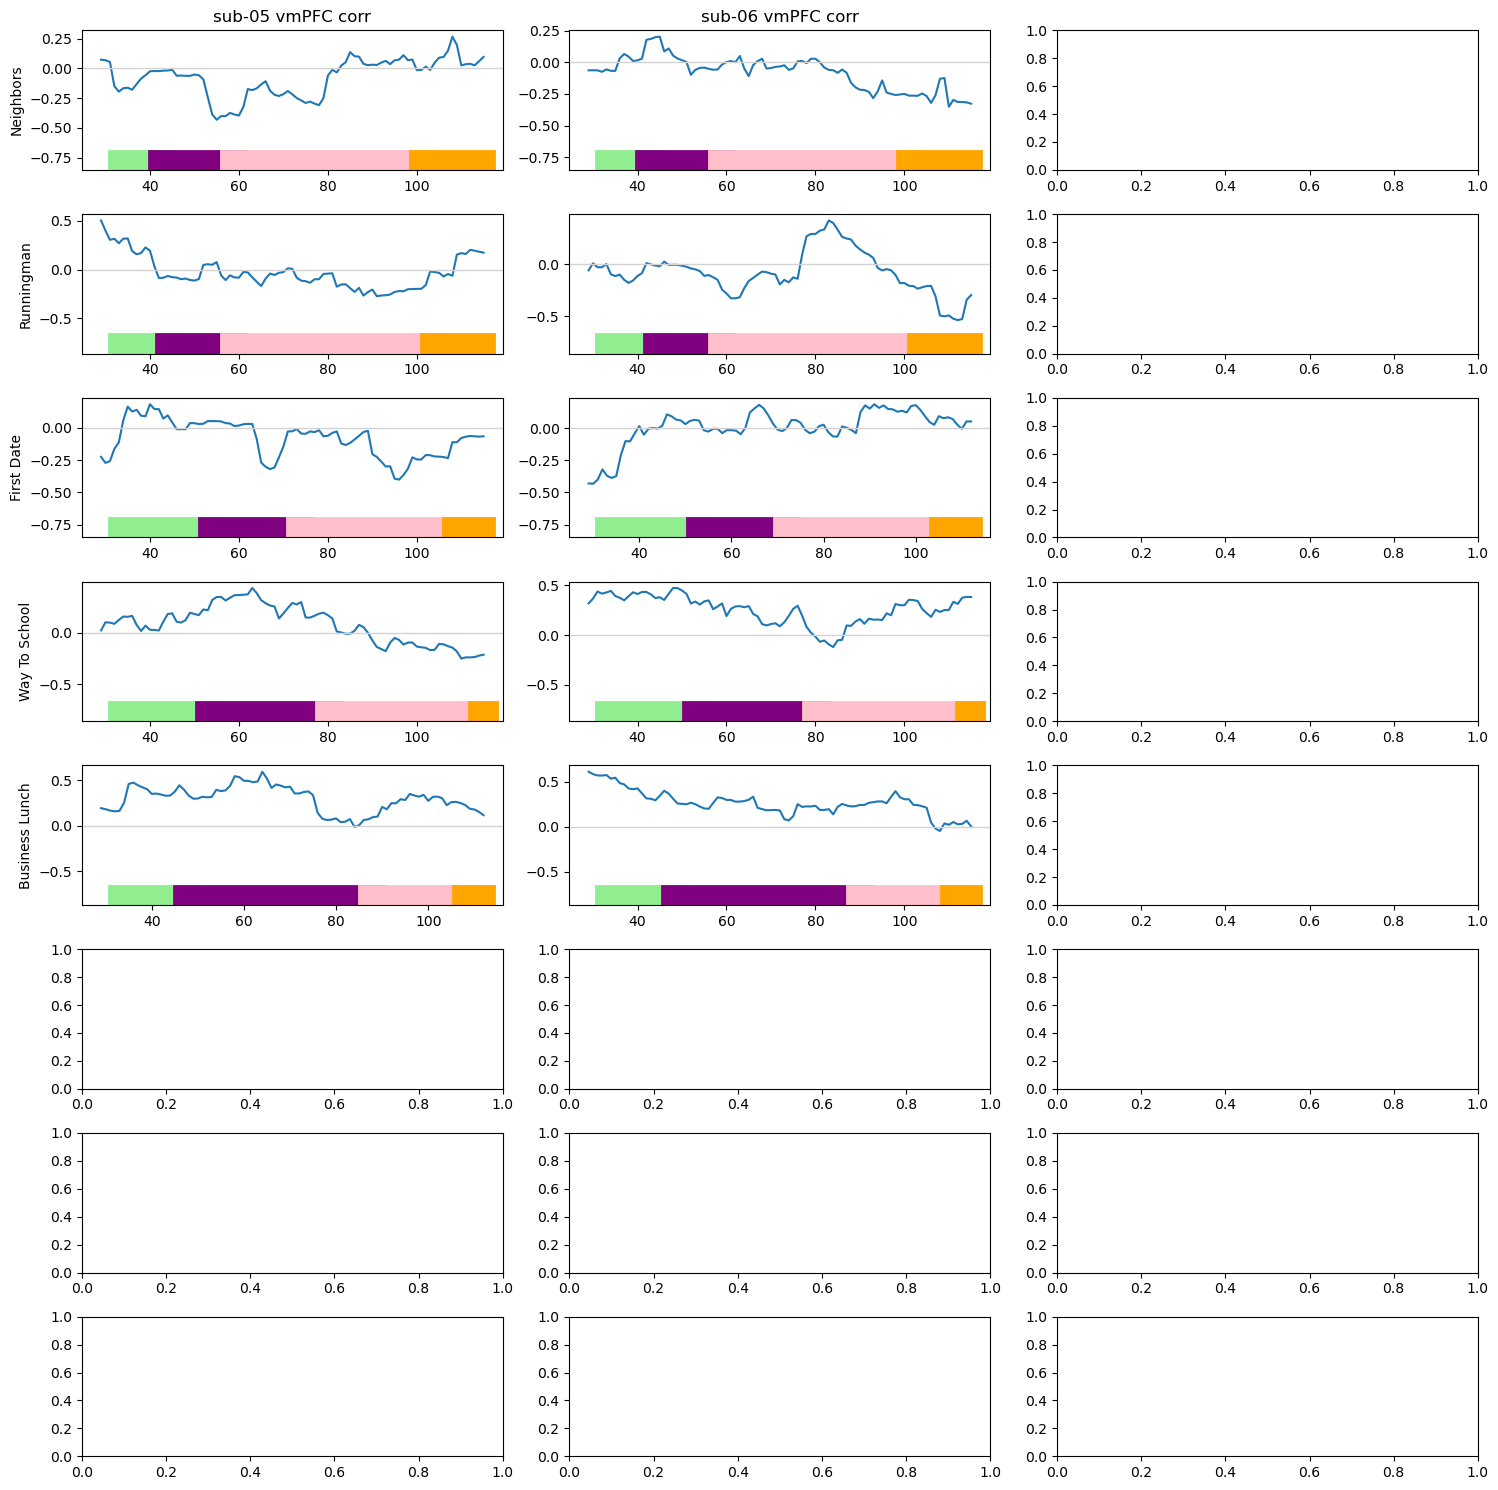

In [411]:
fig, axes = plt.subplots(8, 3, figsize = (15,15))     
#for position, sub in enumerate(['1','3','4']):  
for position, sub in enumerate(['5', '6']):  
    for num in np.arange(all_story['5'].shape[0]):
        story = all_story['5'][num]
        axes[num, position].plot(pd.DataFrame(All_sliding_r[32][sub][story]))
        axes[0, position].set_title(f"sub-0{sub} vmPFC corr")
        axes[num, 0].set_ylabel(f"{story}")
        axes[num, position].axhline(0.0, 0, 1.0, color='lightgray', linestyle='solid', linewidth=1)
        #axes[num, position].axhline(-0.8, 0.05,  story_TR2[story][0]/116, color='lightblue', linestyle='solid', linewidth=20)
        axes[num, position].axhline(-0.8,  story_TR2[story][0]/116, story_TR2[story][1]/116, color='lightgreen', linestyle='solid', linewidth=20)
        axes[num, position].axhline(-0.8,  story_TR2[story][1]/116, story_TR2[story][2]/116, color='purple', linestyle='solid', linewidth=20)
        axes[num, position].axhline(-0.8,  story_TR2[story][2]/116, story_TR2[story][3]/116, color='pink', linestyle='solid', linewidth=20)
        axes[num, position].axhline(-0.8,  story_TR2[story][3]/116,  0.95, color='orange', linestyle='solid',linewidth=20)
        
fig.tight_layout()
#axes[, 4].set_xlabel("30 TRs Window")
plt.show()
fig.savefig('roi-32_vmPFC_S0[5-6].png')

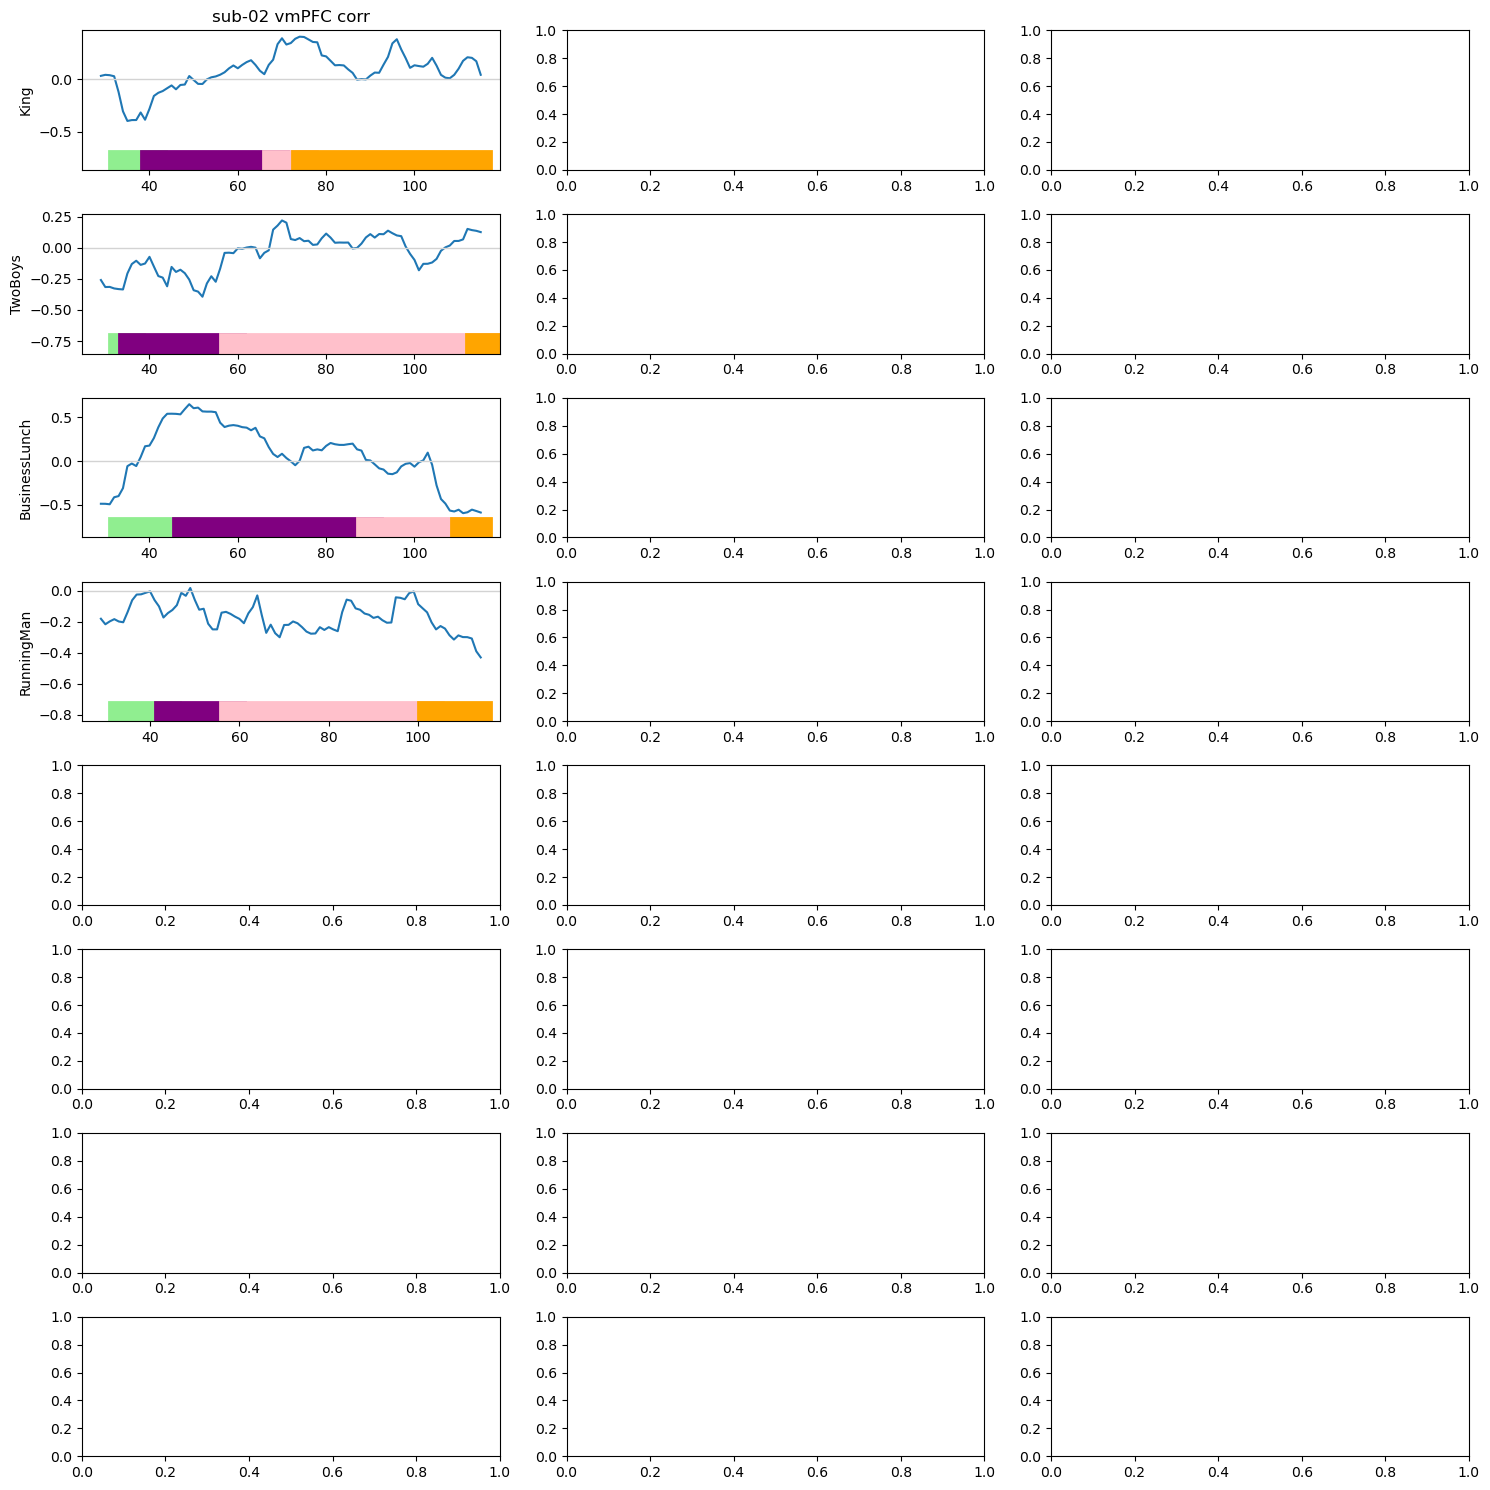

In [418]:
# Plotting sub - 02 & 08 


fig, axes = plt.subplots(8, 3, figsize = (15,15))     
#for position, sub in enumerate(['1','3','4']):  
sub = '2'
for num in np.arange(all_story[sub].shape[0]):
    story = all_story[sub][num]
    axes[num,0].plot(pd.DataFrame(All_sliding_r[32][sub][story]))
    axes[0,0].set_title(f"sub-0{sub} vmPFC corr")
    axes[num,0].set_ylabel(f"{story}")
    axes[num,0].axhline(0.0, 0, 1.0, color='lightgray', linestyle='solid', linewidth=1)
    #axes[num,0].axhline(-0.8, 0.05,  story_TR3[story][0]/116, color='lightblue', linestyle='solid', linewidth=20)
    axes[num,0].axhline(-0.8,  story_TR[story][0]/116, story_TR[story][1]/116, color='lightgreen', linestyle='solid', linewidth=20)
    axes[num,0].axhline(-0.8,  story_TR[story][1]/116, story_TR[story][2]/116, color='purple', linestyle='solid', linewidth=20)
    axes[num,0].axhline(-0.8,  story_TR[story][2]/116, story_TR[story][3]/116, color='pink', linestyle='solid', linewidth=20)
    axes[num,0].axhline(-0.8,  story_TR[story][3]/116,  0.95, color='orange', linestyle='solid',linewidth=20)
        
fig.tight_layout()
plt.show()
fig.savefig(f'roi-32_vmPFC_S0{sub}.png')

IndexingError: Too many indexers

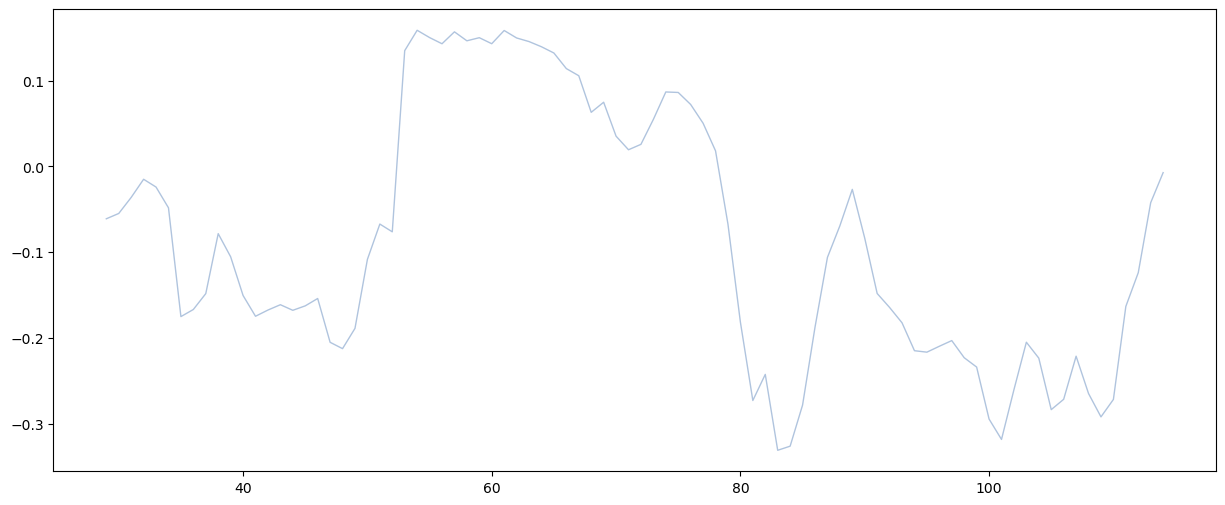

In [242]:
palette = ['darkseagreen', 'darkgray', 'rosybrown', 'dimgrey', 'lightslategray', 'lightsteelblue', 'cadetblue','silver']
#ROIs = [1, 4, 5, 6, 15, 19, 27, 28, 32, 45]

import seaborn as sns
#colors = sns.color_palette('hls',3)

fig, axes = plt.subplots(figsize = (15, 6))     
#for position, sub in enumerate(['1','3','4']):  
sub = '1'
#roi =5
#roi_name = 'HPC'
#for num in np.arange(all_story[sub].shape[0]):
story = 'RunningMan'
#plt.plot(pd.DataFrame(ZROIs[5][sub][story]), color = 'rosybrown',  linewidth= 1, label = 'TPJ')
# # # plt.plot(pd.DataFrame(ZROIs[15][sub][story]), color = 'darkorange',  linewidth= 1)
plt.plot(pd.DataFrame(ZROIs[28][sub][story]), color = 'lightsteelblue', linewidth= 1, label = 'HPC' )
plt.fill_between(ZROIs[6][sub][story].index, 0.0, ZROIs[28][sub][story].loc[:,0], color='lightgray', alpha=0.5)
# #plt.plot(pd.DataFrame(ZROIs[1][sub][story]), color = 'skyblue', linewidth= 0.5, label = 'ParaHPC/Fusiform')

#plt.plot(pd.DataFrame(ZROIs[6][sub][story]), color = 'wheat', linewidth=  1,  label = 'PCC/precuneus')
#plt.plot(pd.DataFrame(ZROIs[19][sub][story]), color = 'sandybrown', linewidth= 1 ) # 얘가 좀 관련이 있어보이는데 그닥..
#plt.plot(pd.DataFrame(ZROIs[32][sub][story]), color = 'orange', linewidth= 0.5, label = 'vmPFC')

#plt.plot(pd.DataFrame(result_sum_dynamic['S2_Change']/30), color = 'green', linewidth= 1)
plt.plot(pd.DataFrame((result_average_dynamic[f'S{sub}_Change'])), color = 'green', linewidth= 2, label ='Behavior Change')

#plt.text(110.0, 0.78, 'Behavior Change')

plt.title(f"sub - 0{sub} {story}", fontsize = 25)
plt.ylabel("Sliding Time window corr")
plt.axhline(0.0, 0, 1.0, color='lightgray', linestyle='solid', linewidth=1)
# plt.axhline(-1.0,  0.05, (story_TR[story][1]-10)/116, color='skyblue', linestyle='solid', linewidth=20)
# plt.axhline(-1.0,  (story_TR[story][1]-10)/116, (story_TR[story][2]-10)/116, color='mediumpurple', linestyle='solid', linewidth=20)
# plt.axhline(-1.0,  (story_TR[story][2]-10)/116, (story_TR[story][3]-10)/116, color='darkseagreen', linestyle='solid', linewidth=20)
# plt.axhline(-1.0,  (story_TR[story][3]-10)/116,  0.95, color='palevioletred', linestyle='solid',linewidth=20)

plt.axhline(-1.0,  0.05, (story_TR3[story][1]-10)/116, color='skyblue', linestyle='solid', linewidth=20)
plt.axhline(-1.0,  (story_TR3[story][1]-10)/116, (story_TR3[story][2]-10)/116, color='mediumpurple', linestyle='solid', linewidth=20)
plt.axhline(-1.0,  (story_TR3[story][2]-10)/116, (story_TR3[story][3]-10)/116, color='darkseagreen', linestyle='solid', linewidth=20)
plt.axhline(-1.0,  (story_TR3[story][3]-10)/116,  0.95, color='palevioletred', linestyle='solid',linewidth=20)
        
fig.tight_layout()
plt.legend()
plt.show()
#fig.savefig(f'S0{sub}_Behav_ROIs_details.png')